In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment, save_ml_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [37]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()
df = df[df['Station'] == 'Amberd2']

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [38]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [40]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.12731e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:16<00:00,  1.15s/it]


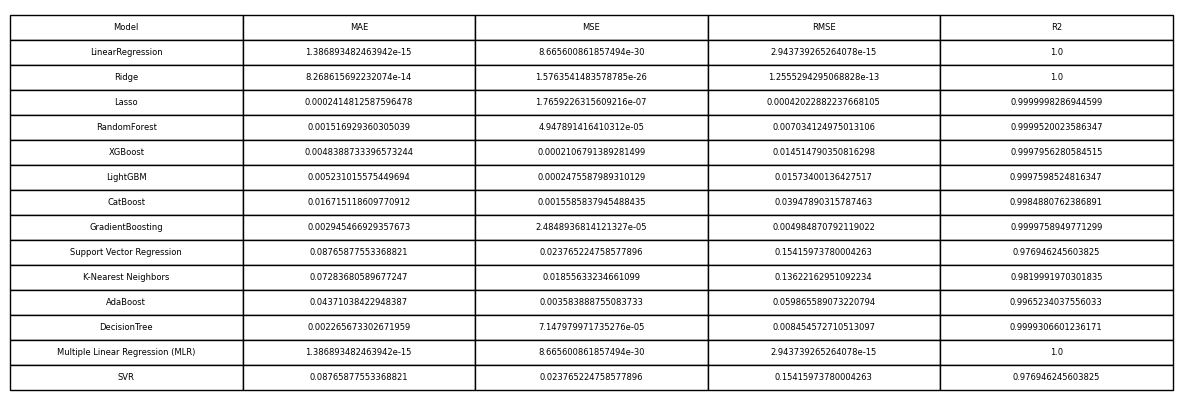

In [41]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

table_fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()
plt.close()

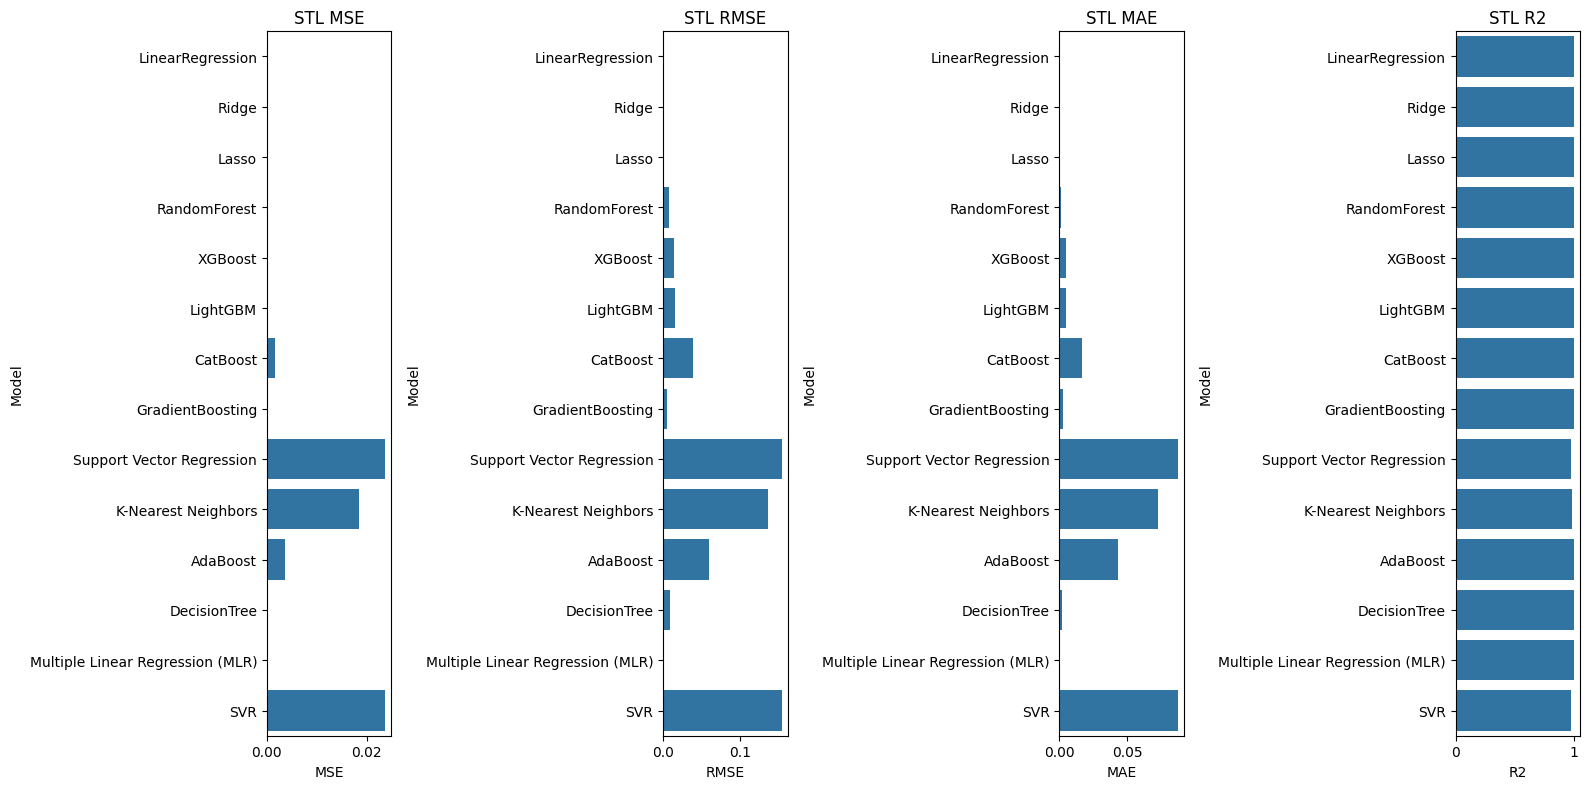

In [42]:
barplot_fig = plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()
plt.close()

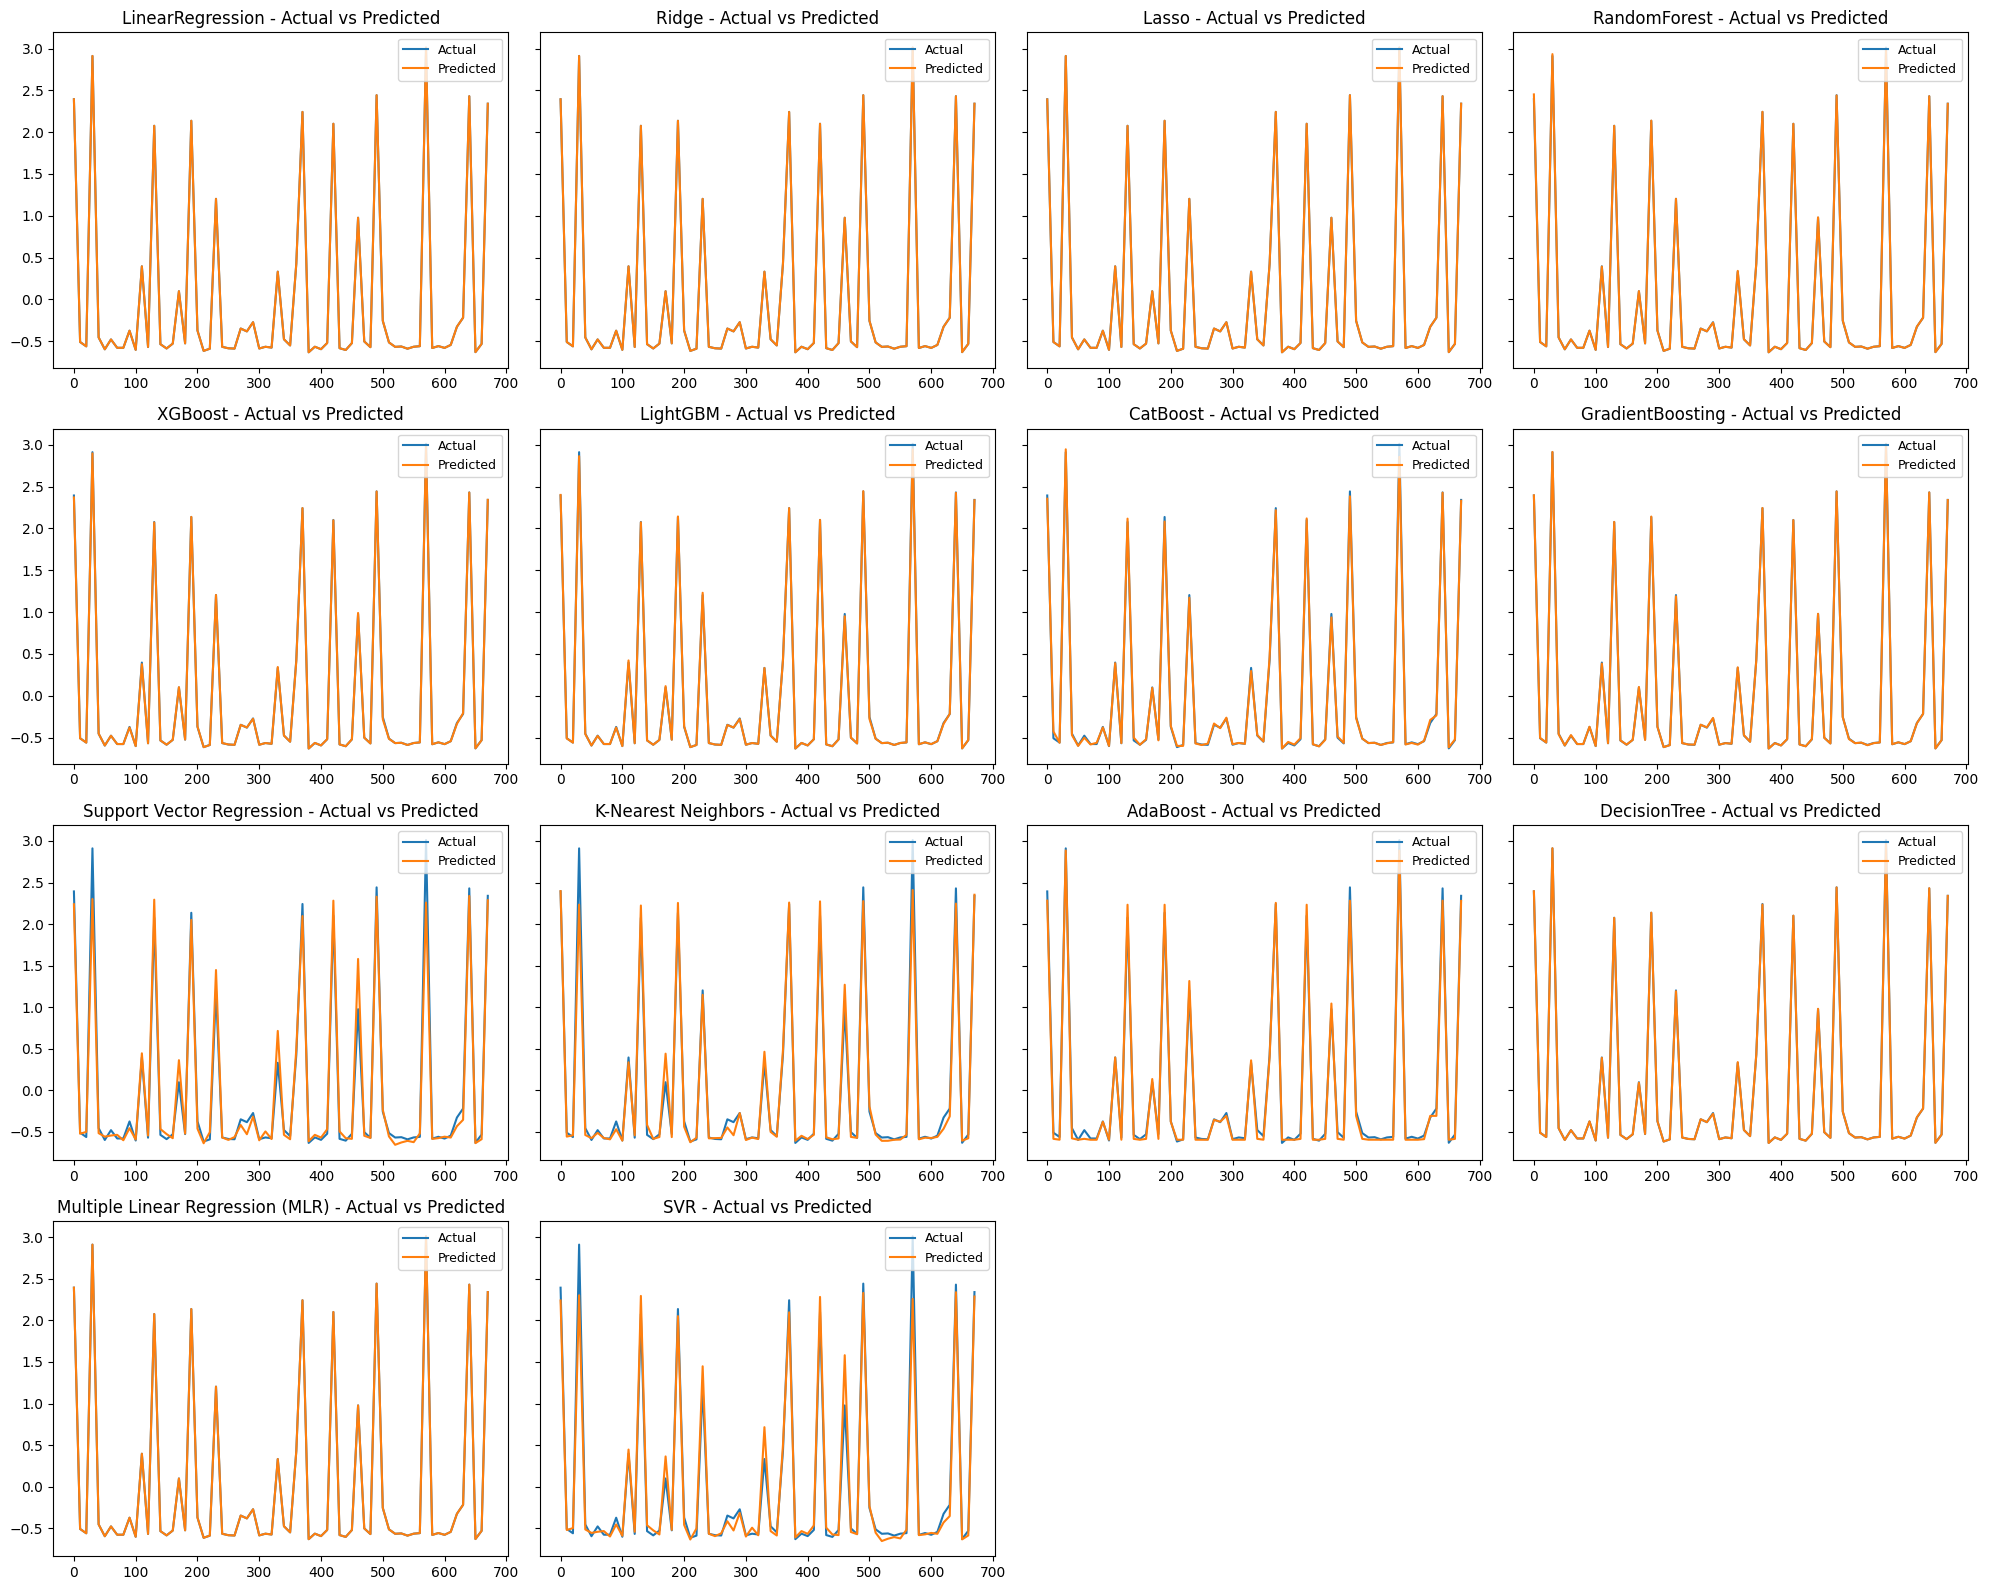

In [43]:
pred_figs = {}
cols_stl = 4
num_models_stl = len(results)
rows_stl = int(np.ceil(num_models_stl / cols_stl))
idx = np.arange(len(y_test))[::10]

fig, axes = plt.subplots(rows_stl, cols_stl, figsize=(20, 16), sharey='row')
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend(fontsize=9, loc="upper right")

for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figs["AllModels"] = fig
plt.show()
plt.close()

In [10]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [11]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [12]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [14]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [15]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [16]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [17]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

  7%|███████▏                                                                                               | 7/100 [00:00<00:02, 31.26it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.1798, RMSE: 0.4240, MAE: 0.2485, R2: 0.8187
Test:  MSE: 0.1851, RMSE: 0.4303, MAE: 0.2475, R2: 0.8204


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 30.85it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0018, RMSE: 0.0425, MAE: 0.0306, R2: 0.9982
Test:  MSE: 0.0025, RMSE: 0.0503, MAE: 0.0356, R2: 0.9975


 23%|███████████████████████▍                                                                              | 23/100 [00:00<00:02, 31.37it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0006, RMSE: 0.0247, MAE: 0.0178, R2: 0.9994
Test:  MSE: 0.0010, RMSE: 0.0309, MAE: 0.0212, R2: 0.9991


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:01<00:02, 31.09it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0003, RMSE: 0.0185, MAE: 0.0131, R2: 0.9997
Test:  MSE: 0.0006, RMSE: 0.0243, MAE: 0.0162, R2: 0.9994


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:01<00:02, 27.30it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0002, RMSE: 0.0153, MAE: 0.0109, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0206, MAE: 0.0140, R2: 0.9996


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 30.64it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0136, MAE: 0.0098, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0190, MAE: 0.0129, R2: 0.9997


 67%|████████████████████████████████████████████████████████████████████▎                                 | 67/100 [00:02<00:00, 35.47it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0119, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0170, MAE: 0.0117, R2: 0.9997


 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [00:02<00:00, 37.87it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0114, MAE: 0.0084, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0170, MAE: 0.0115, R2: 0.9997


 85%|██████████████████████████████████████████████████████████████████████████████████████▋               | 85/100 [00:02<00:00, 37.38it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0108, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0158, MAE: 0.0107, R2: 0.9998


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:02<00:00, 37.38it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0100, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 33.55it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0094, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0150, MAE: 0.0100, R2: 0.9998


  3%|███                                                                                                    | 3/100 [00:00<00:04, 23.10it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0149, RMSE: 0.1219, MAE: 0.0940, R2: 0.9850
Test:  MSE: 0.0142, RMSE: 0.1191, MAE: 0.0894, R2: 0.9862


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:03, 25.00it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0005, RMSE: 0.0222, MAE: 0.0163, R2: 0.9995
Test:  MSE: 0.0008, RMSE: 0.0283, MAE: 0.0188, R2: 0.9992


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:03, 24.19it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0129, MAE: 0.0093, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0205, MAE: 0.0121, R2: 0.9996


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:01<00:02, 24.21it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0109, MAE: 0.0083, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0165, MAE: 0.0107, R2: 0.9997


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:01<00:02, 24.41it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0005, RMSE: 0.0220, MAE: 0.0174, R2: 0.9995
Test:  MSE: 0.0007, RMSE: 0.0265, MAE: 0.0187, R2: 0.9993


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:01, 25.29it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0081, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0088, R2: 0.9998


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:02<00:01, 25.31it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0065, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0077, R2: 0.9999


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:03<00:00, 25.30it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0009, RMSE: 0.0292, MAE: 0.0254, R2: 0.9991
Test:  MSE: 0.0010, RMSE: 0.0323, MAE: 0.0268, R2: 0.9990


 84%|█████████████████████████████████████████████████████████████████████████████████████▋                | 84/100 [00:03<00:00, 26.48it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0134, MAE: 0.0091, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:03<00:00, 26.44it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0151, MAE: 0.0090, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.11it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0039, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0101, MAE: 0.0063, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:05, 16.56it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0114, RMSE: 0.1067, MAE: 0.0796, R2: 0.9885
Test:  MSE: 0.0132, RMSE: 0.1150, MAE: 0.0846, R2: 0.9872


 12%|████████████▏                                                                                         | 12/100 [00:00<00:05, 16.84it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0002, RMSE: 0.0145, MAE: 0.0111, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0173, MAE: 0.0125, R2: 0.9997


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:04, 15.77it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0137, MAE: 0.0090, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:04, 16.73it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0000, RMSE: 0.0063, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0106, MAE: 0.0069, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:02<00:03, 14.75it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0000, RMSE: 0.0069, MAE: 0.0054, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0075, R2: 0.9999


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:02, 16.34it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0143, MAE: 0.0104, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0161, MAE: 0.0115, R2: 0.9997


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:03<00:02, 15.25it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0054, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0111, MAE: 0.0074, R2: 0.9999


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:04<00:01, 16.07it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0100, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0087, R2: 0.9999


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:05<00:01, 16.53it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0095, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0144, MAE: 0.0085, R2: 0.9998


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:05<00:00, 16.98it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0061, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0119, MAE: 0.0078, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 16.36it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0078, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0126, MAE: 0.0089, R2: 0.9998


  1%|█                                                                                                      | 1/100 [00:00<00:21,  4.70it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0108, RMSE: 0.1038, MAE: 0.0726, R2: 0.9891
Test:  MSE: 0.0130, RMSE: 0.1141, MAE: 0.0800, R2: 0.9874


 10%|██████████▏                                                                                           | 10/100 [00:02<00:20,  4.37it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0201, RMSE: 0.1418, MAE: 0.0822, R2: 0.9797
Test:  MSE: 0.0212, RMSE: 0.1455, MAE: 0.0868, R2: 0.9795


 20%|████████████████████▍                                                                                 | 20/100 [00:04<00:17,  4.55it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0065, RMSE: 0.0808, MAE: 0.0672, R2: 0.9934
Test:  MSE: 0.0067, RMSE: 0.0819, MAE: 0.0673, R2: 0.9935


 30%|██████████████████████████████▌                                                                       | 30/100 [00:06<00:18,  3.69it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0090, RMSE: 0.0947, MAE: 0.0679, R2: 0.9910
Test:  MSE: 0.0093, RMSE: 0.0963, MAE: 0.0701, R2: 0.9910


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:09<00:14,  4.04it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0037, RMSE: 0.0608, MAE: 0.0460, R2: 0.9963
Test:  MSE: 0.0040, RMSE: 0.0629, MAE: 0.0473, R2: 0.9962


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:11<00:11,  4.29it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0053, RMSE: 0.0727, MAE: 0.0531, R2: 0.9947
Test:  MSE: 0.0056, RMSE: 0.0749, MAE: 0.0556, R2: 0.9946


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:14<00:09,  4.17it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0072, RMSE: 0.0850, MAE: 0.0649, R2: 0.9927
Test:  MSE: 0.0072, RMSE: 0.0851, MAE: 0.0655, R2: 0.9930


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:16<00:07,  3.84it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0181, RMSE: 0.1346, MAE: 0.0874, R2: 0.9817
Test:  MSE: 0.0182, RMSE: 0.1350, MAE: 0.0889, R2: 0.9823


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:18<00:04,  4.73it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0102, RMSE: 0.1008, MAE: 0.0641, R2: 0.9897
Test:  MSE: 0.0108, RMSE: 0.1038, MAE: 0.0671, R2: 0.9896


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:20<00:01,  7.51it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0069, RMSE: 0.0828, MAE: 0.0547, R2: 0.9931
Test:  MSE: 0.0074, RMSE: 0.0860, MAE: 0.0572, R2: 0.9928


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.58it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0037, RMSE: 0.0608, MAE: 0.0453, R2: 0.9963
Test:  MSE: 0.0040, RMSE: 0.0635, MAE: 0.0465, R2: 0.9961


In [18]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  5%|█████▏                                                                                                 | 5/100 [00:00<00:03, 24.26it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.6096, RMSE: 0.7808, MAE: 0.5899, R2: 0.3852
Test:  MSE: 0.6237, RMSE: 0.7897, MAE: 0.5911, R2: 0.3950


 15%|███████████████▎                                                                                      | 15/100 [00:00<00:02, 38.20it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0115, RMSE: 0.1072, MAE: 0.0782, R2: 0.9884
Test:  MSE: 0.0127, RMSE: 0.1126, MAE: 0.0785, R2: 0.9877


 24%|████████████████████████▍                                                                             | 24/100 [00:00<00:02, 33.01it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0030, RMSE: 0.0550, MAE: 0.0394, R2: 0.9970
Test:  MSE: 0.0036, RMSE: 0.0596, MAE: 0.0419, R2: 0.9965


 37%|█████████████████████████████████████▋                                                                | 37/100 [00:01<00:01, 32.70it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0017, RMSE: 0.0411, MAE: 0.0300, R2: 0.9983
Test:  MSE: 0.0019, RMSE: 0.0439, MAE: 0.0314, R2: 0.9981


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:01<00:01, 33.91it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0012, RMSE: 0.0345, MAE: 0.0252, R2: 0.9988
Test:  MSE: 0.0014, RMSE: 0.0373, MAE: 0.0267, R2: 0.9986


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:01<00:01, 35.37it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0009, RMSE: 0.0300, MAE: 0.0218, R2: 0.9991
Test:  MSE: 0.0011, RMSE: 0.0329, MAE: 0.0231, R2: 0.9989


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:02<00:01, 33.34it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0007, RMSE: 0.0264, MAE: 0.0192, R2: 0.9993
Test:  MSE: 0.0009, RMSE: 0.0297, MAE: 0.0204, R2: 0.9991


 76%|█████████████████████████████████████████████████████████████████████████████▌                        | 76/100 [00:02<00:00, 35.71it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0006, RMSE: 0.0237, MAE: 0.0171, R2: 0.9994
Test:  MSE: 0.0007, RMSE: 0.0272, MAE: 0.0184, R2: 0.9993


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:02<00:00, 29.21it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0005, RMSE: 0.0214, MAE: 0.0153, R2: 0.9995
Test:  MSE: 0.0006, RMSE: 0.0251, MAE: 0.0166, R2: 0.9994


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:03<00:00, 34.13it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0004, RMSE: 0.0197, MAE: 0.0141, R2: 0.9996
Test:  MSE: 0.0006, RMSE: 0.0236, MAE: 0.0154, R2: 0.9995


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 31.28it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0003, RMSE: 0.0182, MAE: 0.0129, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0223, MAE: 0.0143, R2: 0.9995


  1%|█                                                                                                      | 1/100 [00:00<00:22,  4.41it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.1580, RMSE: 0.3974, MAE: 0.2994, R2: 0.8407
Test:  MSE: 0.1575, RMSE: 0.3969, MAE: 0.2956, R2: 0.8472


 10%|██████████▏                                                                                           | 10/100 [00:00<00:06, 13.32it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0018, RMSE: 0.0424, MAE: 0.0311, R2: 0.9982
Test:  MSE: 0.0025, RMSE: 0.0496, MAE: 0.0368, R2: 0.9976


 24%|████████████████████████▍                                                                             | 24/100 [00:01<00:03, 19.42it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0007, RMSE: 0.0272, MAE: 0.0201, R2: 0.9993
Test:  MSE: 0.0010, RMSE: 0.0322, MAE: 0.0237, R2: 0.9990


 32%|████████████████████████████████▋                                                                     | 32/100 [00:01<00:02, 26.80it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0005, RMSE: 0.0215, MAE: 0.0158, R2: 0.9995
Test:  MSE: 0.0007, RMSE: 0.0258, MAE: 0.0187, R2: 0.9994


 39%|███████████████████████████████████████▊                                                              | 39/100 [00:02<00:04, 13.21it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0180, MAE: 0.0133, R2: 0.9997
Test:  MSE: 0.0005, RMSE: 0.0222, MAE: 0.0159, R2: 0.9995


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:04<00:05,  8.96it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0153, MAE: 0.0113, R2: 0.9998
Test:  MSE: 0.0004, RMSE: 0.0193, MAE: 0.0139, R2: 0.9996


 59%|████████████████████████████████████████████████████████████▏                                         | 59/100 [00:04<00:02, 17.19it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0136, MAE: 0.0100, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0175, MAE: 0.0125, R2: 0.9997


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:05<00:01, 25.04it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0120, MAE: 0.0088, R2: 0.9999
Test:  MSE: 0.0003, RMSE: 0.0163, MAE: 0.0113, R2: 0.9997


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:05<00:00, 25.22it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0110, MAE: 0.0081, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0152, MAE: 0.0105, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:06<00:00, 23.57it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0076, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0100, R2: 0.9998


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.58it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0136, MAE: 0.0096, R2: 0.9998


  2%|██                                                                                                     | 2/100 [00:00<00:07, 13.29it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.2207, RMSE: 0.4698, MAE: 0.3079, R2: 0.7774
Test:  MSE: 0.2266, RMSE: 0.4761, MAE: 0.3115, R2: 0.7801


 11%|███████████▏                                                                                          | 11/100 [00:02<00:14,  6.11it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0010, RMSE: 0.0310, MAE: 0.0223, R2: 0.9990
Test:  MSE: 0.0012, RMSE: 0.0347, MAE: 0.0244, R2: 0.9988


 24%|████████████████████████▍                                                                             | 24/100 [00:02<00:03, 20.12it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0003, RMSE: 0.0176, MAE: 0.0132, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0196, MAE: 0.0142, R2: 0.9996


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:03<00:02, 22.86it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0002, RMSE: 0.0131, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0157, MAE: 0.0111, R2: 0.9998


 45%|█████████████████████████████████████████████▉                                                        | 45/100 [00:03<00:02, 24.56it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0108, MAE: 0.0079, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0097, R2: 0.9998


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:03<00:01, 25.08it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0066, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0126, MAE: 0.0085, R2: 0.9998


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:04<00:01, 23.31it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0118, MAE: 0.0079, R2: 0.9999


 75%|████████████████████████████████████████████████████████████████████████████▌                         | 75/100 [00:04<00:00, 25.58it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0072, MAE: 0.0053, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0075, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:04<00:00, 24.76it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0109, MAE: 0.0073, R2: 0.9999


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:05<00:00, 22.01it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0068, MAE: 0.0053, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0074, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 16.79it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0058, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0102, MAE: 0.0066, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:11,  8.55it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0684, RMSE: 0.2616, MAE: 0.2040, R2: 0.9310
Test:  MSE: 0.0694, RMSE: 0.2635, MAE: 0.2054, R2: 0.9327


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  7.37it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0075, RMSE: 0.0866, MAE: 0.0734, R2: 0.9924
Test:  MSE: 0.0075, RMSE: 0.0865, MAE: 0.0732, R2: 0.9927


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:10,  7.87it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0041, RMSE: 0.0642, MAE: 0.0454, R2: 0.9958
Test:  MSE: 0.0042, RMSE: 0.0652, MAE: 0.0471, R2: 0.9959


 30%|██████████████████████████████▌                                                                       | 30/100 [00:04<00:13,  5.35it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0043, RMSE: 0.0653, MAE: 0.0564, R2: 0.9957
Test:  MSE: 0.0043, RMSE: 0.0652, MAE: 0.0553, R2: 0.9959


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:06<00:12,  4.91it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0026, RMSE: 0.0515, MAE: 0.0436, R2: 0.9973
Test:  MSE: 0.0030, RMSE: 0.0545, MAE: 0.0454, R2: 0.9971


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:08<00:06,  7.17it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0033, RMSE: 0.0577, MAE: 0.0496, R2: 0.9966
Test:  MSE: 0.0037, RMSE: 0.0610, MAE: 0.0516, R2: 0.9964


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:11<00:17,  2.20it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0022, RMSE: 0.0469, MAE: 0.0368, R2: 0.9978
Test:  MSE: 0.0023, RMSE: 0.0483, MAE: 0.0379, R2: 0.9977


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:13<00:04,  6.26it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0045, RMSE: 0.0668, MAE: 0.0586, R2: 0.9955
Test:  MSE: 0.0050, RMSE: 0.0706, MAE: 0.0600, R2: 0.9952


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:14<00:02,  8.57it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0049, RMSE: 0.0703, MAE: 0.0558, R2: 0.9950
Test:  MSE: 0.0048, RMSE: 0.0696, MAE: 0.0548, R2: 0.9953


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:15<00:01,  8.14it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0069, RMSE: 0.0833, MAE: 0.0618, R2: 0.9930
Test:  MSE: 0.0070, RMSE: 0.0839, MAE: 0.0623, R2: 0.9932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.65it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0037, RMSE: 0.0608, MAE: 0.0489, R2: 0.9963
Test:  MSE: 0.0038, RMSE: 0.0616, MAE: 0.0489, R2: 0.9963


  4%|████                                                                                                   | 4/100 [00:00<00:03, 31.11it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.5901, RMSE: 0.7682, MAE: 0.6559, R2: 0.4048
Test:  MSE: 0.6001, RMSE: 0.7746, MAE: 0.6537, R2: 0.4179


 14%|██████████████▎                                                                                       | 14/100 [00:00<00:03, 27.60it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0091, RMSE: 0.0954, MAE: 0.0795, R2: 0.9908
Test:  MSE: 0.0098, RMSE: 0.0989, MAE: 0.0814, R2: 0.9905


 20%|████████████████████▍                                                                                 | 20/100 [00:01<00:07, 10.16it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0056, RMSE: 0.0747, MAE: 0.0596, R2: 0.9944
Test:  MSE: 0.0063, RMSE: 0.0796, MAE: 0.0625, R2: 0.9939


 31%|███████████████████████████████▌                                                                      | 31/100 [00:02<00:04, 14.40it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0058, RMSE: 0.0759, MAE: 0.0576, R2: 0.9942
Test:  MSE: 0.0062, RMSE: 0.0785, MAE: 0.0599, R2: 0.9940


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:02<00:04, 12.77it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0046, RMSE: 0.0678, MAE: 0.0523, R2: 0.9954
Test:  MSE: 0.0051, RMSE: 0.0713, MAE: 0.0548, R2: 0.9951


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:04<00:06,  8.00it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0039, RMSE: 0.0624, MAE: 0.0482, R2: 0.9961
Test:  MSE: 0.0045, RMSE: 0.0670, MAE: 0.0507, R2: 0.9957


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:05<00:04,  8.39it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0056, RMSE: 0.0752, MAE: 0.0535, R2: 0.9943
Test:  MSE: 0.0062, RMSE: 0.0790, MAE: 0.0565, R2: 0.9940


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:07<00:04,  7.08it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0047, RMSE: 0.0687, MAE: 0.0526, R2: 0.9952
Test:  MSE: 0.0052, RMSE: 0.0721, MAE: 0.0546, R2: 0.9950


 79%|████████████████████████████████████████████████████████████████████████████████▌                     | 79/100 [00:08<00:02,  7.40it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0060, RMSE: 0.0772, MAE: 0.0516, R2: 0.9940
Test:  MSE: 0.0067, RMSE: 0.0816, MAE: 0.0558, R2: 0.9935


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:09<00:00, 11.25it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0066, RMSE: 0.0810, MAE: 0.0529, R2: 0.9934
Test:  MSE: 0.0070, RMSE: 0.0836, MAE: 0.0555, R2: 0.9932


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.96it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0036, RMSE: 0.0602, MAE: 0.0431, R2: 0.9963
Test:  MSE: 0.0040, RMSE: 0.0632, MAE: 0.0446, R2: 0.9961


  3%|███                                                                                                    | 3/100 [00:00<00:03, 28.11it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.5879, RMSE: 0.7667, MAE: 0.5944, R2: 0.4071
Test:  MSE: 0.6110, RMSE: 0.7817, MAE: 0.5998, R2: 0.4073


 12%|████████████▏                                                                                         | 12/100 [00:00<00:04, 20.95it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0081, RMSE: 0.0898, MAE: 0.0670, R2: 0.9919
Test:  MSE: 0.0097, RMSE: 0.0986, MAE: 0.0741, R2: 0.9906


 24%|████████████████████████▍                                                                             | 24/100 [00:01<00:03, 22.74it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0063, RMSE: 0.0792, MAE: 0.0576, R2: 0.9937
Test:  MSE: 0.0074, RMSE: 0.0859, MAE: 0.0631, R2: 0.9928


 35%|███████████████████████████████████▋                                                                  | 35/100 [00:01<00:02, 28.74it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0096, RMSE: 0.0977, MAE: 0.0638, R2: 0.9904
Test:  MSE: 0.0105, RMSE: 0.1024, MAE: 0.0696, R2: 0.9898


 46%|██████████████████████████████████████████████▉                                                       | 46/100 [00:01<00:01, 28.78it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0043, RMSE: 0.0653, MAE: 0.0464, R2: 0.9957
Test:  MSE: 0.0053, RMSE: 0.0727, MAE: 0.0517, R2: 0.9949


 54%|███████████████████████████████████████████████████████                                               | 54/100 [00:02<00:01, 30.47it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0022, RMSE: 0.0466, MAE: 0.0345, R2: 0.9978
Test:  MSE: 0.0025, RMSE: 0.0499, MAE: 0.0370, R2: 0.9976


 66%|███████████████████████████████████████████████████████████████████▎                                  | 66/100 [00:02<00:01, 33.39it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0045, RMSE: 0.0668, MAE: 0.0445, R2: 0.9955
Test:  MSE: 0.0051, RMSE: 0.0717, MAE: 0.0486, R2: 0.9950


 74%|███████████████████████████████████████████████████████████████████████████▍                          | 74/100 [00:02<00:00, 31.47it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0026, RMSE: 0.0511, MAE: 0.0401, R2: 0.9974
Test:  MSE: 0.0028, RMSE: 0.0531, MAE: 0.0418, R2: 0.9973


 86%|███████████████████████████████████████████████████████████████████████████████████████▋              | 86/100 [00:03<00:00, 34.14it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0061, RMSE: 0.0782, MAE: 0.0508, R2: 0.9938
Test:  MSE: 0.0066, RMSE: 0.0810, MAE: 0.0533, R2: 0.9936


 94%|███████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:03<00:00, 34.51it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0020, RMSE: 0.0451, MAE: 0.0327, R2: 0.9979
Test:  MSE: 0.0024, RMSE: 0.0485, MAE: 0.0348, R2: 0.9977


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 28.91it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0034, RMSE: 0.0581, MAE: 0.0418, R2: 0.9966
Test:  MSE: 0.0037, RMSE: 0.0608, MAE: 0.0432, R2: 0.9964


In [19]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [20]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     97   0.000080  0.000189    0.008929   0.013742   0.006458   
1  Net2    100   0.000025  0.000102    0.004983   0.010093   0.003868   
2  Net3     72   0.000023  0.000080    0.004772   0.008961   0.003695   
3  Net4     78   0.002349  0.002367    0.048466   0.048654   0.033202   

   Test MAE  Train R2   Test R2  
0  0.009214  0.999920  0.999817  
1  0.006285  0.999975  0.999901  
2  0.005674  0.999977  0.999922  
3  0.033646  0.997631  0.997704

In [21]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     98   0.001555  0.001852    0.039431   0.043037   0.029954   
1      FNN     99   0.002931  0.003307    0.054141   0.057510   0.040296   
2     Net1    100   0.000333  0.000498    0.018245   0.022306   0.012947   
3     Net2     98   0.000082  0.000185    0.009059   0.013615   0.006739   
4     Net3     97   0.000032  0.000094    0.005652   0.009684   0.004257   
5     Net4     25   0.001422  0.001737    0.037713   0.041681   0.028777   

   Test MAE  Train R2   Test R2  
0  0.031771  0.998432  0.998203  
1  0.041988  0.997044  0.996792  
2  0.014324  0.999664  0.999517  
3  0.009343  0.999917  0.999820  
4  0.006411  0.999968  0.999909  
5  0.031754  0.998566  0.998315

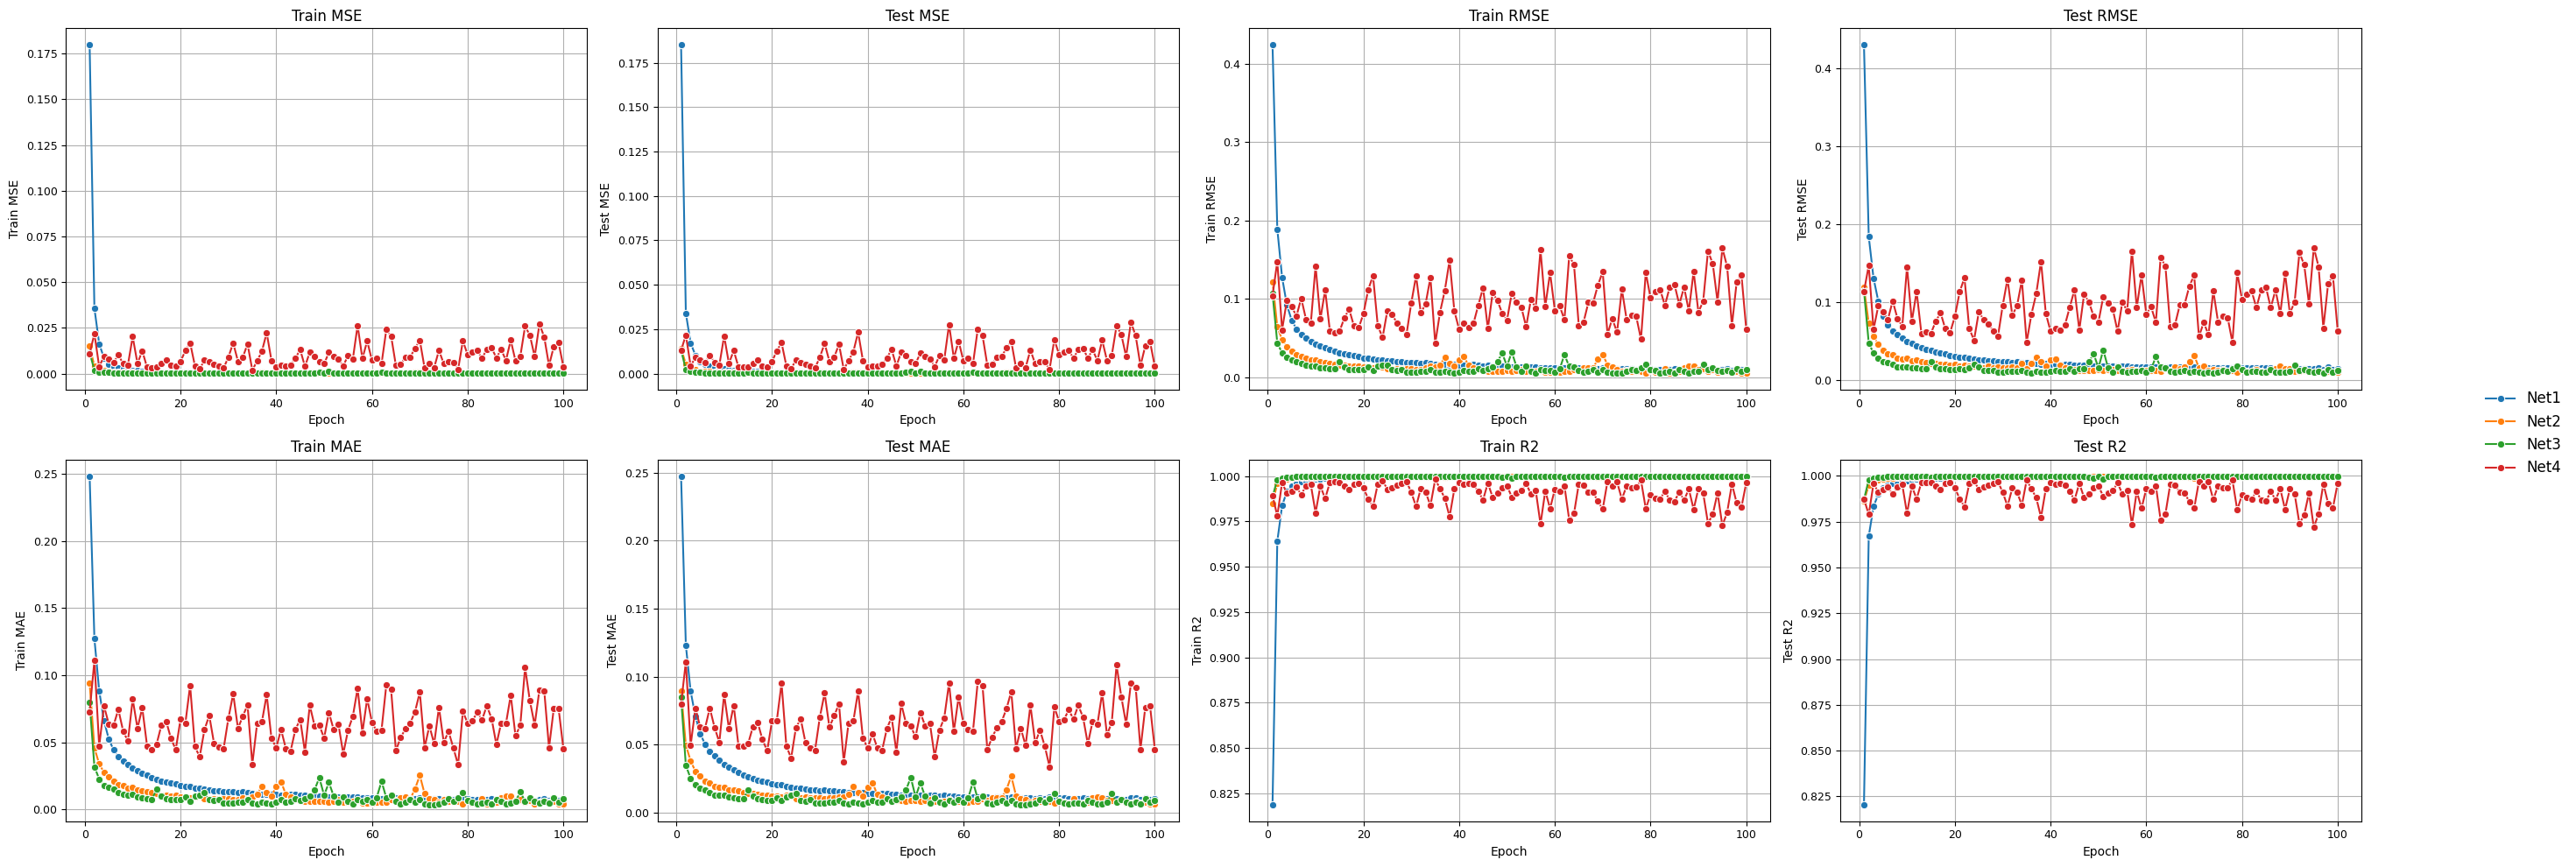

In [27]:
train_figures = {}

metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

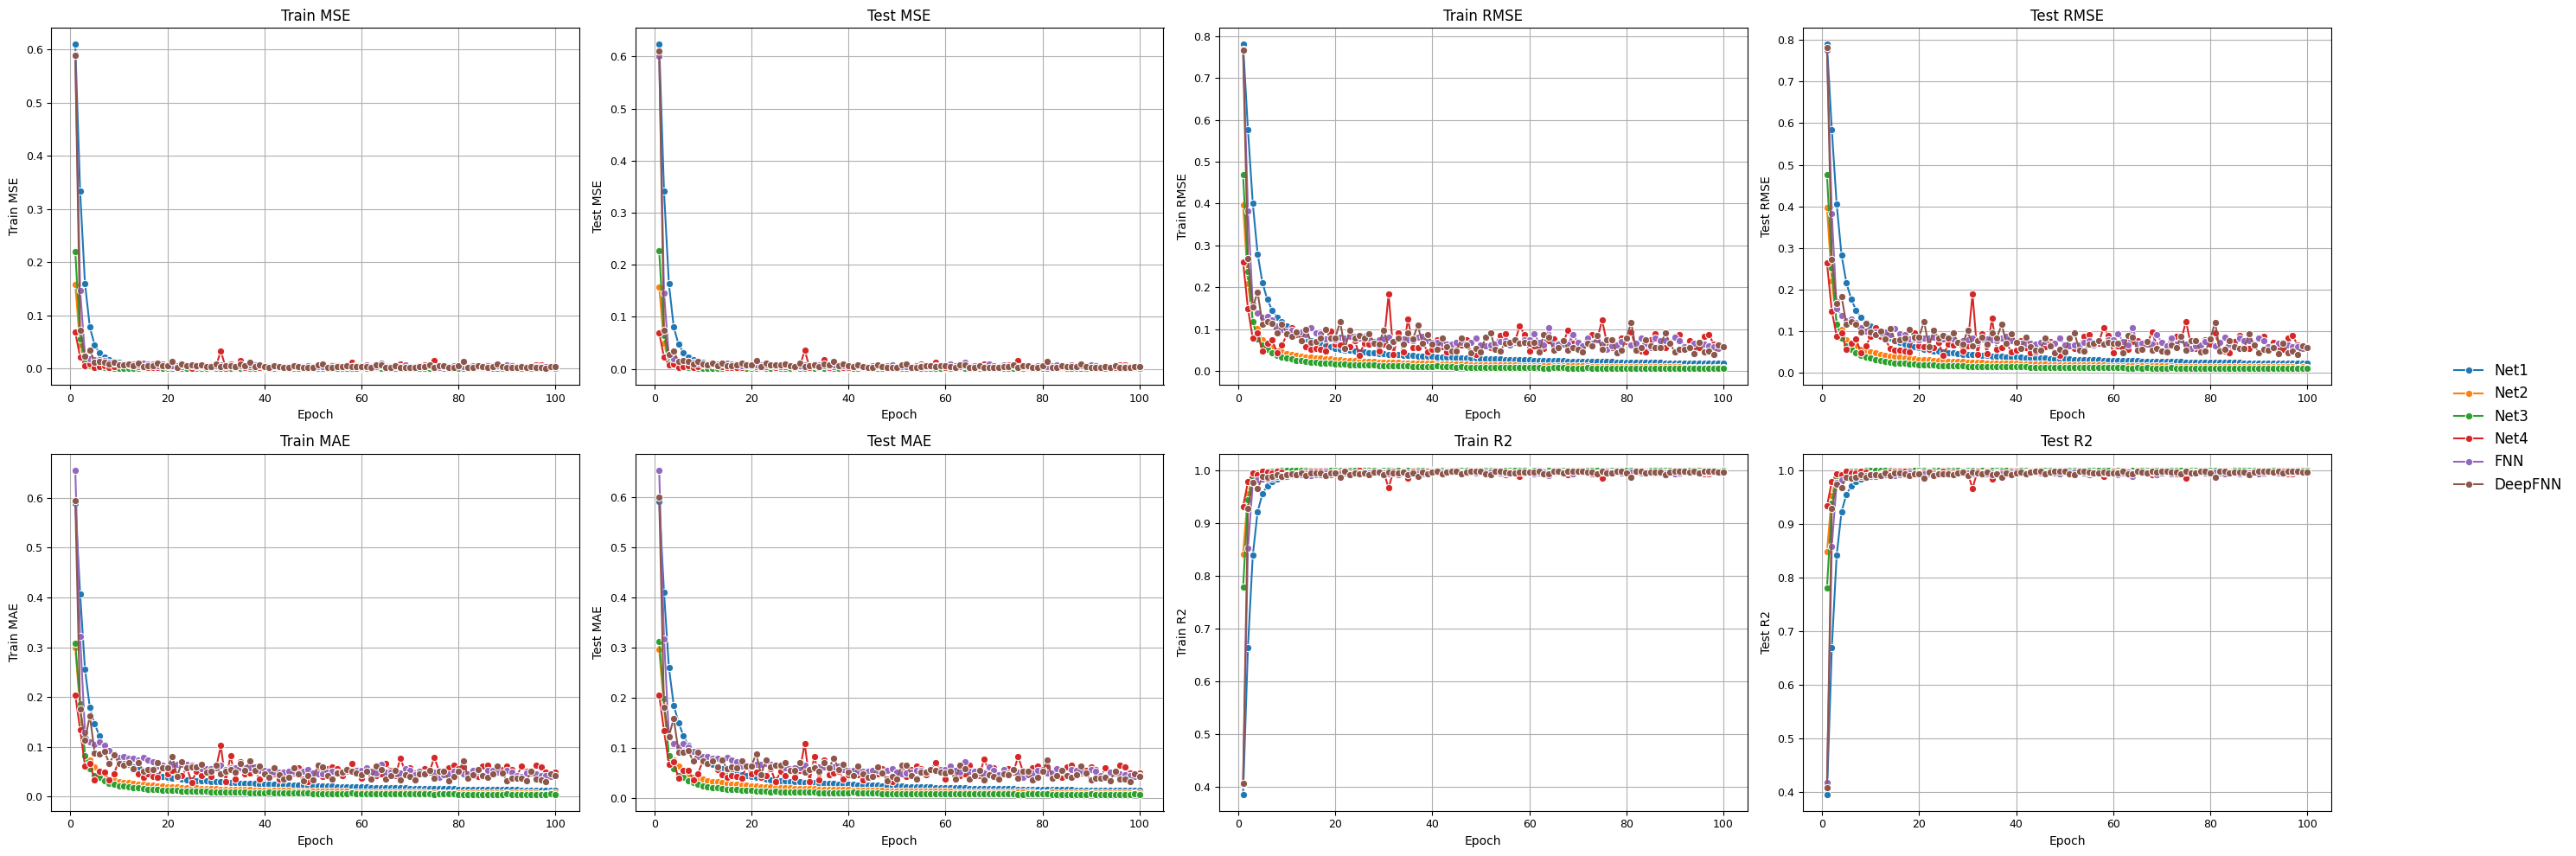

In [28]:
train_figures_tabular = {}

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [25]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [26]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:   1%|▉                                                                                        | 1/100 [00:04<07:01,  4.26s/it]


Model: TCN | Epoch: 1/100
Train: MSE: 0.0390, RMSE: 0.1974, MAE: 0.1196, R2: 0.9611
Test:  MSE: 0.0966, RMSE: 0.3108, MAE: 0.2594, R2: 0.9606


Training TCN:  10%|████████▊                                                                               | 10/100 [00:34<04:53,  3.26s/it]


Model: TCN | Epoch: 10/100
Train: MSE: 0.0200, RMSE: 0.1416, MAE: 0.0792, R2: 0.9800
Test:  MSE: 0.0962, RMSE: 0.3102, MAE: 0.2751, R2: 0.9607


Training TCN:  20%|█████████████████▌                                                                      | 20/100 [01:07<04:24,  3.31s/it]


Model: TCN | Epoch: 20/100
Train: MSE: 0.0153, RMSE: 0.1237, MAE: 0.0716, R2: 0.9847
Test:  MSE: 0.0594, RMSE: 0.2438, MAE: 0.2098, R2: 0.9757


Training TCN:  30%|██████████████████████████▍                                                             | 30/100 [01:44<04:17,  3.68s/it]


Model: TCN | Epoch: 30/100
Train: MSE: 0.0125, RMSE: 0.1116, MAE: 0.0624, R2: 0.9876
Test:  MSE: 0.0262, RMSE: 0.1620, MAE: 0.1261, R2: 0.9893


Training TCN:  40%|███████████████████████████████████▏                                                    | 40/100 [02:53<05:16,  5.28s/it]


Model: TCN | Epoch: 40/100
Train: MSE: 0.0120, RMSE: 0.1096, MAE: 0.0623, R2: 0.9880
Test:  MSE: 0.0270, RMSE: 0.1644, MAE: 0.1395, R2: 0.9890


Training TCN:  50%|████████████████████████████████████████████                                            | 50/100 [03:38<03:17,  3.96s/it]


Model: TCN | Epoch: 50/100
Train: MSE: 0.0100, RMSE: 0.0998, MAE: 0.0546, R2: 0.9900
Test:  MSE: 0.0367, RMSE: 0.1915, MAE: 0.1664, R2: 0.9850


Training TCN:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [04:13<02:15,  3.39s/it]


Model: TCN | Epoch: 60/100
Train: MSE: 0.0092, RMSE: 0.0957, MAE: 0.0543, R2: 0.9909
Test:  MSE: 0.0274, RMSE: 0.1655, MAE: 0.1416, R2: 0.9888


Training TCN:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [04:46<01:41,  3.38s/it]


Model: TCN | Epoch: 70/100
Train: MSE: 0.0082, RMSE: 0.0908, MAE: 0.0503, R2: 0.9918
Test:  MSE: 0.0414, RMSE: 0.2035, MAE: 0.1756, R2: 0.9831


Training TCN:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [05:20<01:08,  3.41s/it]


Model: TCN | Epoch: 80/100
Train: MSE: 0.0077, RMSE: 0.0875, MAE: 0.0494, R2: 0.9924
Test:  MSE: 0.0526, RMSE: 0.2292, MAE: 0.1915, R2: 0.9786


Training TCN:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [05:55<00:34,  3.48s/it]


Model: TCN | Epoch: 90/100
Train: MSE: 0.0086, RMSE: 0.0926, MAE: 0.0558, R2: 0.9914
Test:  MSE: 0.0403, RMSE: 0.2007, MAE: 0.1689, R2: 0.9836


Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:30<00:00,  3.91s/it]



Model: TCN | Epoch: 100/100
Train: MSE: 0.0075, RMSE: 0.0863, MAE: 0.0490, R2: 0.9926
Test:  MSE: 0.0326, RMSE: 0.1807, MAE: 0.1561, R2: 0.9867


Training CNN1D:   1%|▊                                                                                      | 1/100 [00:00<00:39,  2.52it/s]


Model: CNN1D | Epoch: 1/100
Train: MSE: 0.2917, RMSE: 0.5401, MAE: 0.2909, R2: 0.7087
Test:  MSE: 2.2115, RMSE: 1.4871, MAE: 1.3596, R2: 0.0976


Training CNN1D:  10%|████████▌                                                                             | 10/100 [00:04<00:40,  2.22it/s]


Model: CNN1D | Epoch: 10/100
Train: MSE: 0.0336, RMSE: 0.1832, MAE: 0.1035, R2: 0.9665
Test:  MSE: 0.1408, RMSE: 0.3753, MAE: 0.2921, R2: 0.9425


Training CNN1D:  20%|█████████████████▏                                                                    | 20/100 [00:08<00:32,  2.44it/s]


Model: CNN1D | Epoch: 20/100
Train: MSE: 0.0264, RMSE: 0.1626, MAE: 0.0843, R2: 0.9736
Test:  MSE: 0.0615, RMSE: 0.2480, MAE: 0.2221, R2: 0.9749


Training CNN1D:  30%|█████████████████████████▊                                                            | 30/100 [00:12<00:29,  2.33it/s]


Model: CNN1D | Epoch: 30/100
Train: MSE: 0.0234, RMSE: 0.1530, MAE: 0.0865, R2: 0.9766
Test:  MSE: 0.0625, RMSE: 0.2501, MAE: 0.2244, R2: 0.9745


Training CNN1D:  40%|██████████████████████████████████▍                                                   | 40/100 [00:17<00:29,  2.00it/s]


Model: CNN1D | Epoch: 40/100
Train: MSE: 0.0200, RMSE: 0.1415, MAE: 0.0822, R2: 0.9800
Test:  MSE: 0.0355, RMSE: 0.1885, MAE: 0.1664, R2: 0.9855


Training CNN1D:  50%|███████████████████████████████████████████                                           | 50/100 [00:23<00:28,  1.76it/s]


Model: CNN1D | Epoch: 50/100
Train: MSE: 0.0189, RMSE: 0.1377, MAE: 0.0791, R2: 0.9811
Test:  MSE: 0.0388, RMSE: 0.1971, MAE: 0.1722, R2: 0.9842


Training CNN1D:  60%|███████████████████████████████████████████████████▌                                  | 60/100 [00:29<00:22,  1.79it/s]


Model: CNN1D | Epoch: 60/100
Train: MSE: 0.0163, RMSE: 0.1277, MAE: 0.0715, R2: 0.9837
Test:  MSE: 0.0300, RMSE: 0.1732, MAE: 0.1529, R2: 0.9878


Training CNN1D:  70%|████████████████████████████████████████████████████████████▏                         | 70/100 [00:34<00:16,  1.84it/s]


Model: CNN1D | Epoch: 70/100
Train: MSE: 0.0166, RMSE: 0.1289, MAE: 0.0679, R2: 0.9834
Test:  MSE: 0.0286, RMSE: 0.1690, MAE: 0.1418, R2: 0.9883


Training CNN1D:  80%|████████████████████████████████████████████████████████████████████▊                 | 80/100 [00:40<00:10,  1.85it/s]


Model: CNN1D | Epoch: 80/100
Train: MSE: 0.0145, RMSE: 0.1206, MAE: 0.0643, R2: 0.9855
Test:  MSE: 0.0217, RMSE: 0.1472, MAE: 0.1263, R2: 0.9912


Training CNN1D:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [00:45<00:05,  1.97it/s]


Model: CNN1D | Epoch: 90/100
Train: MSE: 0.0141, RMSE: 0.1186, MAE: 0.0613, R2: 0.9860
Test:  MSE: 0.0160, RMSE: 0.1264, MAE: 0.1020, R2: 0.9935


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.94it/s]



Model: CNN1D | Epoch: 100/100
Train: MSE: 0.0135, RMSE: 0.1163, MAE: 0.0639, R2: 0.9865
Test:  MSE: 0.0289, RMSE: 0.1700, MAE: 0.1299, R2: 0.9882


Training GRUNet:   1%|▊                                                                                     | 1/100 [00:00<00:43,  2.28it/s]


Model: GRUNet | Epoch: 1/100
Train: MSE: 0.2755, RMSE: 0.5249, MAE: 0.2945, R2: 0.7249
Test:  MSE: 1.9112, RMSE: 1.3825, MAE: 1.3017, R2: 0.2201


Training GRUNet:  10%|████████▌                                                                            | 10/100 [00:03<00:25,  3.60it/s]


Model: GRUNet | Epoch: 10/100
Train: MSE: 0.0236, RMSE: 0.1535, MAE: 0.0783, R2: 0.9765
Test:  MSE: 0.1624, RMSE: 0.4030, MAE: 0.2923, R2: 0.9337


Training GRUNet:  20%|█████████████████                                                                    | 20/100 [00:06<00:23,  3.47it/s]


Model: GRUNet | Epoch: 20/100
Train: MSE: 0.0178, RMSE: 0.1334, MAE: 0.0752, R2: 0.9822
Test:  MSE: 0.2061, RMSE: 0.4539, MAE: 0.3173, R2: 0.9159


Training GRUNet:  30%|█████████████████████████▌                                                           | 30/100 [00:09<00:25,  2.80it/s]


Model: GRUNet | Epoch: 30/100
Train: MSE: 0.0136, RMSE: 0.1168, MAE: 0.0593, R2: 0.9864
Test:  MSE: 0.1402, RMSE: 0.3745, MAE: 0.2553, R2: 0.9428


Training GRUNet:  40%|██████████████████████████████████                                                   | 40/100 [00:12<00:17,  3.35it/s]


Model: GRUNet | Epoch: 40/100
Train: MSE: 0.0118, RMSE: 0.1088, MAE: 0.0537, R2: 0.9882
Test:  MSE: 0.1309, RMSE: 0.3619, MAE: 0.2458, R2: 0.9466


Training GRUNet:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:15<00:14,  3.34it/s]


Model: GRUNet | Epoch: 50/100
Train: MSE: 0.0103, RMSE: 0.1016, MAE: 0.0553, R2: 0.9897
Test:  MSE: 0.0993, RMSE: 0.3151, MAE: 0.2225, R2: 0.9595


Training GRUNet:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:18<00:12,  3.10it/s]


Model: GRUNet | Epoch: 60/100
Train: MSE: 0.0095, RMSE: 0.0974, MAE: 0.0507, R2: 0.9905
Test:  MSE: 0.1063, RMSE: 0.3261, MAE: 0.2099, R2: 0.9566


Training GRUNet:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:22<00:11,  2.57it/s]


Model: GRUNet | Epoch: 70/100
Train: MSE: 0.0093, RMSE: 0.0965, MAE: 0.0549, R2: 0.9907
Test:  MSE: 0.2053, RMSE: 0.4531, MAE: 0.2917, R2: 0.9162


Training GRUNet:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:25<00:06,  3.00it/s]


Model: GRUNet | Epoch: 80/100
Train: MSE: 0.0068, RMSE: 0.0827, MAE: 0.0457, R2: 0.9932
Test:  MSE: 0.1532, RMSE: 0.3914, MAE: 0.2502, R2: 0.9375


Training GRUNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:30<00:04,  2.48it/s]


Model: GRUNet | Epoch: 90/100
Train: MSE: 0.0066, RMSE: 0.0810, MAE: 0.0439, R2: 0.9934
Test:  MSE: 0.1081, RMSE: 0.3288, MAE: 0.2201, R2: 0.9559


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:33<00:00,  2.96it/s]



Model: GRUNet | Epoch: 100/100
Train: MSE: 0.0054, RMSE: 0.0735, MAE: 0.0477, R2: 0.9946
Test:  MSE: 0.1719, RMSE: 0.4146, MAE: 0.2505, R2: 0.9299


Training RNNNet:   1%|▊                                                                                     | 1/100 [00:00<00:29,  3.39it/s]


Model: RNNNet | Epoch: 1/100
Train: MSE: 0.0423, RMSE: 0.2056, MAE: 0.1222, R2: 0.9578
Test:  MSE: 0.1088, RMSE: 0.3299, MAE: 0.2751, R2: 0.9556


Training RNNNet:  11%|█████████▎                                                                           | 11/100 [00:02<00:14,  5.94it/s]


Model: RNNNet | Epoch: 10/100
Train: MSE: 0.0174, RMSE: 0.1320, MAE: 0.0702, R2: 0.9826
Test:  MSE: 0.0200, RMSE: 0.1413, MAE: 0.1095, R2: 0.9919


Training RNNNet:  20%|█████████████████                                                                    | 20/100 [00:04<00:18,  4.36it/s]


Model: RNNNet | Epoch: 20/100
Train: MSE: 0.0155, RMSE: 0.1243, MAE: 0.0687, R2: 0.9846
Test:  MSE: 0.0449, RMSE: 0.2119, MAE: 0.1564, R2: 0.9817


Training RNNNet:  30%|█████████████████████████▌                                                           | 30/100 [00:06<00:15,  4.47it/s]


Model: RNNNet | Epoch: 30/100
Train: MSE: 0.0121, RMSE: 0.1101, MAE: 0.0574, R2: 0.9879
Test:  MSE: 0.0733, RMSE: 0.2708, MAE: 0.2021, R2: 0.9701


Training RNNNet:  41%|██████████████████████████████████▊                                                  | 41/100 [00:08<00:10,  5.79it/s]


Model: RNNNet | Epoch: 40/100
Train: MSE: 0.0144, RMSE: 0.1202, MAE: 0.0741, R2: 0.9856
Test:  MSE: 0.1502, RMSE: 0.3876, MAE: 0.3099, R2: 0.9387


Training RNNNet:  51%|███████████████████████████████████████████▎                                         | 51/100 [00:10<00:09,  5.02it/s]


Model: RNNNet | Epoch: 50/100
Train: MSE: 0.0115, RMSE: 0.1072, MAE: 0.0609, R2: 0.9885
Test:  MSE: 0.1129, RMSE: 0.3360, MAE: 0.2550, R2: 0.9539


Training RNNNet:  61%|███████████████████████████████████████████████████▊                                 | 61/100 [00:12<00:07,  5.23it/s]


Model: RNNNet | Epoch: 60/100
Train: MSE: 0.0108, RMSE: 0.1037, MAE: 0.0638, R2: 0.9893
Test:  MSE: 0.1041, RMSE: 0.3227, MAE: 0.2536, R2: 0.9575


Training RNNNet:  71%|████████████████████████████████████████████████████████████▎                        | 71/100 [00:13<00:04,  6.09it/s]


Model: RNNNet | Epoch: 70/100
Train: MSE: 0.0116, RMSE: 0.1077, MAE: 0.0626, R2: 0.9884
Test:  MSE: 0.2003, RMSE: 0.4475, MAE: 0.3231, R2: 0.9183


Training RNNNet:  81%|████████████████████████████████████████████████████████████████████▊                | 81/100 [00:15<00:03,  5.28it/s]


Model: RNNNet | Epoch: 80/100
Train: MSE: 0.0079, RMSE: 0.0890, MAE: 0.0546, R2: 0.9921
Test:  MSE: 0.2290, RMSE: 0.4785, MAE: 0.3710, R2: 0.9066


Training RNNNet:  91%|█████████████████████████████████████████████████████████████████████████████▎       | 91/100 [00:17<00:01,  5.22it/s]


Model: RNNNet | Epoch: 90/100
Train: MSE: 0.0065, RMSE: 0.0809, MAE: 0.0469, R2: 0.9935
Test:  MSE: 0.1488, RMSE: 0.3857, MAE: 0.2801, R2: 0.9393


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.13it/s]



Model: RNNNet | Epoch: 100/100
Train: MSE: 0.0053, RMSE: 0.0726, MAE: 0.0400, R2: 0.9947
Test:  MSE: 0.1799, RMSE: 0.4242, MAE: 0.3213, R2: 0.9266


Training CNNLSTM:   1%|▊                                                                                    | 1/100 [00:06<11:13,  6.80s/it]


Model: CNNLSTM | Epoch: 1/100
Train: MSE: 0.4753, RMSE: 0.6894, MAE: 0.4523, R2: 0.5254
Test:  MSE: 3.2258, RMSE: 1.7961, MAE: 1.7621, R2: -0.3163


Training CNNLSTM:  10%|████████▍                                                                           | 10/100 [01:03<09:35,  6.39s/it]


Model: CNNLSTM | Epoch: 10/100
Train: MSE: 0.0528, RMSE: 0.2298, MAE: 0.1303, R2: 0.9473
Test:  MSE: 0.0480, RMSE: 0.2192, MAE: 0.1592, R2: 0.9804


Training CNNLSTM:  20%|████████████████▊                                                                   | 20/100 [02:03<08:02,  6.03s/it]


Model: CNNLSTM | Epoch: 20/100
Train: MSE: 0.0350, RMSE: 0.1871, MAE: 0.1005, R2: 0.9651
Test:  MSE: 0.0468, RMSE: 0.2163, MAE: 0.1667, R2: 0.9809


Training CNNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [03:05<07:09,  6.14s/it]


Model: CNNLSTM | Epoch: 30/100
Train: MSE: 0.0302, RMSE: 0.1737, MAE: 0.0948, R2: 0.9699
Test:  MSE: 0.0464, RMSE: 0.2155, MAE: 0.1646, R2: 0.9811


Training CNNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [04:06<05:54,  5.91s/it]


Model: CNNLSTM | Epoch: 40/100
Train: MSE: 0.0253, RMSE: 0.1591, MAE: 0.0869, R2: 0.9747
Test:  MSE: 0.0428, RMSE: 0.2069, MAE: 0.1636, R2: 0.9825


Training CNNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [05:05<05:03,  6.08s/it]


Model: CNNLSTM | Epoch: 50/100
Train: MSE: 0.0288, RMSE: 0.1697, MAE: 0.0969, R2: 0.9712
Test:  MSE: 0.0589, RMSE: 0.2427, MAE: 0.1822, R2: 0.9760


Training CNNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [06:07<04:05,  6.13s/it]


Model: CNNLSTM | Epoch: 60/100
Train: MSE: 0.0211, RMSE: 0.1451, MAE: 0.0794, R2: 0.9790
Test:  MSE: 0.0525, RMSE: 0.2292, MAE: 0.1948, R2: 0.9786


Training CNNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [07:09<03:13,  6.46s/it]


Model: CNNLSTM | Epoch: 70/100
Train: MSE: 0.0187, RMSE: 0.1367, MAE: 0.0760, R2: 0.9813
Test:  MSE: 0.0448, RMSE: 0.2116, MAE: 0.1695, R2: 0.9817


Training CNNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [08:21<02:22,  7.12s/it]


Model: CNNLSTM | Epoch: 80/100
Train: MSE: 0.0175, RMSE: 0.1323, MAE: 0.0744, R2: 0.9825
Test:  MSE: 0.0759, RMSE: 0.2756, MAE: 0.2243, R2: 0.9690


Training CNNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [09:19<00:58,  5.80s/it]


Model: CNNLSTM | Epoch: 90/100
Train: MSE: 0.0188, RMSE: 0.1373, MAE: 0.0763, R2: 0.9812
Test:  MSE: 0.0458, RMSE: 0.2140, MAE: 0.1732, R2: 0.9813


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [10:14<00:00,  6.14s/it]



Model: CNNLSTM | Epoch: 100/100
Train: MSE: 0.0145, RMSE: 0.1206, MAE: 0.0681, R2: 0.9855
Test:  MSE: 0.0410, RMSE: 0.2024, MAE: 0.1640, R2: 0.9833


Training BiLSTMNet:   1%|▊                                                                                  | 1/100 [00:00<01:17,  1.28it/s]


Model: BiLSTMNet | Epoch: 1/100
Train: MSE: 0.2744, RMSE: 0.5238, MAE: 0.2739, R2: 0.7260
Test:  MSE: 2.2241, RMSE: 1.4913, MAE: 1.1718, R2: 0.0925


Training BiLSTMNet:  10%|████████▏                                                                         | 10/100 [00:08<01:11,  1.25it/s]


Model: BiLSTMNet | Epoch: 10/100
Train: MSE: 0.0367, RMSE: 0.1917, MAE: 0.1035, R2: 0.9633
Test:  MSE: 0.5240, RMSE: 0.7239, MAE: 0.4622, R2: 0.7862


Training BiLSTMNet:  20%|████████████████▍                                                                 | 20/100 [00:16<01:04,  1.23it/s]


Model: BiLSTMNet | Epoch: 20/100
Train: MSE: 0.0219, RMSE: 0.1479, MAE: 0.0770, R2: 0.9782
Test:  MSE: 0.3335, RMSE: 0.5775, MAE: 0.3583, R2: 0.8639


Training BiLSTMNet:  30%|████████████████████████▌                                                         | 30/100 [00:24<00:55,  1.26it/s]


Model: BiLSTMNet | Epoch: 30/100
Train: MSE: 0.0182, RMSE: 0.1349, MAE: 0.0713, R2: 0.9818
Test:  MSE: 0.2524, RMSE: 0.5024, MAE: 0.3171, R2: 0.8970


Training BiLSTMNet:  40%|████████████████████████████████▊                                                 | 40/100 [00:32<00:51,  1.16it/s]


Model: BiLSTMNet | Epoch: 40/100
Train: MSE: 0.0155, RMSE: 0.1245, MAE: 0.0690, R2: 0.9845
Test:  MSE: 0.1909, RMSE: 0.4369, MAE: 0.2818, R2: 0.9221


Training BiLSTMNet:  50%|█████████████████████████████████████████                                         | 50/100 [00:40<00:41,  1.22it/s]


Model: BiLSTMNet | Epoch: 50/100
Train: MSE: 0.0131, RMSE: 0.1144, MAE: 0.0619, R2: 0.9869
Test:  MSE: 0.1624, RMSE: 0.4030, MAE: 0.2622, R2: 0.9337


Training BiLSTMNet:  60%|█████████████████████████████████████████████████▏                                | 60/100 [00:48<00:32,  1.22it/s]


Model: BiLSTMNet | Epoch: 60/100
Train: MSE: 0.0118, RMSE: 0.1087, MAE: 0.0618, R2: 0.9882
Test:  MSE: 0.1852, RMSE: 0.4304, MAE: 0.2824, R2: 0.9244


Training BiLSTMNet:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [00:57<00:25,  1.16it/s]


Model: BiLSTMNet | Epoch: 70/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0606, R2: 0.9896
Test:  MSE: 0.1468, RMSE: 0.3831, MAE: 0.2413, R2: 0.9401


Training BiLSTMNet:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:05<00:16,  1.18it/s]


Model: BiLSTMNet | Epoch: 80/100
Train: MSE: 0.0095, RMSE: 0.0974, MAE: 0.0584, R2: 0.9905
Test:  MSE: 0.1791, RMSE: 0.4233, MAE: 0.2620, R2: 0.9269


Training BiLSTMNet:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:14<00:09,  1.10it/s]


Model: BiLSTMNet | Epoch: 90/100
Train: MSE: 0.0080, RMSE: 0.0897, MAE: 0.0501, R2: 0.9920
Test:  MSE: 0.1657, RMSE: 0.4071, MAE: 0.2566, R2: 0.9324


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]



Model: BiLSTMNet | Epoch: 100/100
Train: MSE: 0.0071, RMSE: 0.0841, MAE: 0.0487, R2: 0.9929
Test:  MSE: 0.1465, RMSE: 0.3827, MAE: 0.2498, R2: 0.9402


Training DeepLSTMNet:   1%|▊                                                                                | 1/100 [00:01<02:41,  1.63s/it]


Model: DeepLSTMNet | Epoch: 1/100
Train: MSE: 0.1289, RMSE: 0.3590, MAE: 0.2081, R2: 0.8713
Test:  MSE: 0.4253, RMSE: 0.6521, MAE: 0.4433, R2: 0.8265


Training DeepLSTMNet:  10%|████████                                                                        | 10/100 [00:15<02:20,  1.56s/it]


Model: DeepLSTMNet | Epoch: 10/100
Train: MSE: 0.0575, RMSE: 0.2397, MAE: 0.1262, R2: 0.9426
Test:  MSE: 0.2370, RMSE: 0.4868, MAE: 0.3158, R2: 0.9033


Training DeepLSTMNet:  20%|████████████████                                                                | 20/100 [00:33<02:32,  1.90s/it]


Model: DeepLSTMNet | Epoch: 20/100
Train: MSE: 0.0345, RMSE: 0.1856, MAE: 0.0994, R2: 0.9656
Test:  MSE: 0.0420, RMSE: 0.2049, MAE: 0.1420, R2: 0.9829


Training DeepLSTMNet:  30%|████████████████████████                                                        | 30/100 [00:50<02:07,  1.82s/it]


Model: DeepLSTMNet | Epoch: 30/100
Train: MSE: 0.0221, RMSE: 0.1486, MAE: 0.0765, R2: 0.9779
Test:  MSE: 0.0546, RMSE: 0.2338, MAE: 0.1590, R2: 0.9777


Training DeepLSTMNet:  40%|████████████████████████████████                                                | 40/100 [01:07<01:39,  1.66s/it]


Model: DeepLSTMNet | Epoch: 40/100
Train: MSE: 0.0229, RMSE: 0.1512, MAE: 0.0819, R2: 0.9772
Test:  MSE: 0.0747, RMSE: 0.2734, MAE: 0.1649, R2: 0.9695


Training DeepLSTMNet:  50%|████████████████████████████████████████                                        | 50/100 [01:23<01:24,  1.69s/it]


Model: DeepLSTMNet | Epoch: 50/100
Train: MSE: 0.0193, RMSE: 0.1391, MAE: 0.0742, R2: 0.9807
Test:  MSE: 0.0363, RMSE: 0.1904, MAE: 0.1239, R2: 0.9852


Training DeepLSTMNet:  60%|████████████████████████████████████████████████                                | 60/100 [01:40<01:06,  1.67s/it]


Model: DeepLSTMNet | Epoch: 60/100
Train: MSE: 0.0158, RMSE: 0.1256, MAE: 0.0699, R2: 0.9843
Test:  MSE: 0.0525, RMSE: 0.2291, MAE: 0.1643, R2: 0.9786


Training DeepLSTMNet:  70%|████████████████████████████████████████████████████████                        | 70/100 [01:58<00:52,  1.73s/it]


Model: DeepLSTMNet | Epoch: 70/100
Train: MSE: 0.0122, RMSE: 0.1106, MAE: 0.0609, R2: 0.9878
Test:  MSE: 0.0504, RMSE: 0.2245, MAE: 0.1680, R2: 0.9794


Training DeepLSTMNet:  80%|████████████████████████████████████████████████████████████████                | 80/100 [02:15<00:35,  1.77s/it]


Model: DeepLSTMNet | Epoch: 80/100
Train: MSE: 0.0094, RMSE: 0.0972, MAE: 0.0542, R2: 0.9906
Test:  MSE: 0.1002, RMSE: 0.3166, MAE: 0.2152, R2: 0.9591


Training DeepLSTMNet:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [02:32<00:16,  1.63s/it]


Model: DeepLSTMNet | Epoch: 90/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0549, R2: 0.9896
Test:  MSE: 0.1143, RMSE: 0.3381, MAE: 0.2464, R2: 0.9533


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [02:48<00:00,  1.69s/it]



Model: DeepLSTMNet | Epoch: 100/100
Train: MSE: 0.0072, RMSE: 0.0848, MAE: 0.0478, R2: 0.9928
Test:  MSE: 0.1201, RMSE: 0.3466, MAE: 0.2273, R2: 0.9510


Training CNNBiLSTM:   1%|▊                                                                                  | 1/100 [00:01<01:55,  1.17s/it]


Model: CNNBiLSTM | Epoch: 1/100
Train: MSE: 0.2580, RMSE: 0.5079, MAE: 0.3015, R2: 0.7424
Test:  MSE: 1.6831, RMSE: 1.2974, MAE: 1.2067, R2: 0.3132


Training CNNBiLSTM:  10%|████████▏                                                                         | 10/100 [00:12<01:48,  1.20s/it]


Model: CNNBiLSTM | Epoch: 10/100
Train: MSE: 0.0228, RMSE: 0.1510, MAE: 0.0818, R2: 0.9772
Test:  MSE: 0.0592, RMSE: 0.2433, MAE: 0.2019, R2: 0.9759


Training CNNBiLSTM:  20%|████████████████▍                                                                 | 20/100 [00:23<01:36,  1.21s/it]


Model: CNNBiLSTM | Epoch: 20/100
Train: MSE: 0.0208, RMSE: 0.1441, MAE: 0.0771, R2: 0.9793
Test:  MSE: 0.0251, RMSE: 0.1585, MAE: 0.1336, R2: 0.9898


Training CNNBiLSTM:  30%|████████████████████████▌                                                         | 30/100 [00:35<01:21,  1.17s/it]


Model: CNNBiLSTM | Epoch: 30/100
Train: MSE: 0.0157, RMSE: 0.1254, MAE: 0.0667, R2: 0.9843
Test:  MSE: 0.0500, RMSE: 0.2236, MAE: 0.1844, R2: 0.9796


Training CNNBiLSTM:  40%|████████████████████████████████▊                                                 | 40/100 [00:47<01:10,  1.18s/it]


Model: CNNBiLSTM | Epoch: 40/100
Train: MSE: 0.0146, RMSE: 0.1210, MAE: 0.0634, R2: 0.9854
Test:  MSE: 0.0261, RMSE: 0.1615, MAE: 0.1305, R2: 0.9894


Training CNNBiLSTM:  50%|█████████████████████████████████████████                                         | 50/100 [01:00<01:02,  1.24s/it]


Model: CNNBiLSTM | Epoch: 50/100
Train: MSE: 0.0131, RMSE: 0.1147, MAE: 0.0604, R2: 0.9869
Test:  MSE: 0.0428, RMSE: 0.2068, MAE: 0.1733, R2: 0.9826


Training CNNBiLSTM:  60%|█████████████████████████████████████████████████▏                                | 60/100 [01:12<00:49,  1.23s/it]


Model: CNNBiLSTM | Epoch: 60/100
Train: MSE: 0.0136, RMSE: 0.1167, MAE: 0.0625, R2: 0.9864
Test:  MSE: 0.0554, RMSE: 0.2353, MAE: 0.1926, R2: 0.9774


Training CNNBiLSTM:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [01:23<00:35,  1.17s/it]


Model: CNNBiLSTM | Epoch: 70/100
Train: MSE: 0.0124, RMSE: 0.1113, MAE: 0.0645, R2: 0.9876
Test:  MSE: 0.0635, RMSE: 0.2519, MAE: 0.1982, R2: 0.9741


Training CNNBiLSTM:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [01:35<00:22,  1.13s/it]


Model: CNNBiLSTM | Epoch: 80/100
Train: MSE: 0.0111, RMSE: 0.1053, MAE: 0.0592, R2: 0.9889
Test:  MSE: 0.0502, RMSE: 0.2240, MAE: 0.1712, R2: 0.9795


Training CNNBiLSTM:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [01:46<00:11,  1.11s/it]


Model: CNNBiLSTM | Epoch: 90/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0555, R2: 0.9896
Test:  MSE: 0.0440, RMSE: 0.2096, MAE: 0.1737, R2: 0.9821


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]



Model: CNNBiLSTM | Epoch: 100/100
Train: MSE: 0.0098, RMSE: 0.0991, MAE: 0.0538, R2: 0.9902
Test:  MSE: 0.0430, RMSE: 0.2074, MAE: 0.1602, R2: 0.9824


Training GRUCNN:   1%|▊                                                                                     | 1/100 [00:00<00:54,  1.83it/s]


Model: GRUCNN | Epoch: 1/100
Train: MSE: 0.2552, RMSE: 0.5052, MAE: 0.2631, R2: 0.7451
Test:  MSE: 1.8576, RMSE: 1.3629, MAE: 1.2132, R2: 0.2420


Training GRUCNN:  10%|████████▌                                                                            | 10/100 [00:05<00:49,  1.80it/s]


Model: GRUCNN | Epoch: 10/100
Train: MSE: 0.0364, RMSE: 0.1907, MAE: 0.1005, R2: 0.9637
Test:  MSE: 0.2689, RMSE: 0.5186, MAE: 0.3340, R2: 0.8903


Training GRUCNN:  20%|█████████████████                                                                    | 20/100 [00:11<00:44,  1.78it/s]


Model: GRUCNN | Epoch: 20/100
Train: MSE: 0.0261, RMSE: 0.1616, MAE: 0.0819, R2: 0.9739
Test:  MSE: 0.1942, RMSE: 0.4406, MAE: 0.2873, R2: 0.9208


Training GRUCNN:  30%|█████████████████████████▌                                                           | 30/100 [00:16<00:38,  1.81it/s]


Model: GRUCNN | Epoch: 30/100
Train: MSE: 0.0232, RMSE: 0.1523, MAE: 0.0756, R2: 0.9768
Test:  MSE: 0.1488, RMSE: 0.3858, MAE: 0.2475, R2: 0.9393


Training GRUCNN:  40%|██████████████████████████████████                                                   | 40/100 [00:21<00:30,  1.95it/s]


Model: GRUCNN | Epoch: 40/100
Train: MSE: 0.0207, RMSE: 0.1440, MAE: 0.0738, R2: 0.9793
Test:  MSE: 0.2008, RMSE: 0.4481, MAE: 0.2824, R2: 0.9181


Training GRUCNN:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:27<00:26,  1.85it/s]


Model: GRUCNN | Epoch: 50/100
Train: MSE: 0.0190, RMSE: 0.1380, MAE: 0.0764, R2: 0.9810
Test:  MSE: 0.0699, RMSE: 0.2644, MAE: 0.1802, R2: 0.9715


Training GRUCNN:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:32<00:22,  1.79it/s]


Model: GRUCNN | Epoch: 60/100
Train: MSE: 0.0178, RMSE: 0.1335, MAE: 0.0752, R2: 0.9822
Test:  MSE: 0.0873, RMSE: 0.2955, MAE: 0.1911, R2: 0.9644


Training GRUCNN:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:37<00:15,  1.93it/s]


Model: GRUCNN | Epoch: 70/100
Train: MSE: 0.0152, RMSE: 0.1234, MAE: 0.0655, R2: 0.9848
Test:  MSE: 0.1388, RMSE: 0.3726, MAE: 0.2320, R2: 0.9433


Training GRUCNN:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:43<00:11,  1.79it/s]


Model: GRUCNN | Epoch: 80/100
Train: MSE: 0.0155, RMSE: 0.1247, MAE: 0.0789, R2: 0.9845
Test:  MSE: 0.2107, RMSE: 0.4590, MAE: 0.2839, R2: 0.9140


Training GRUCNN:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:48<00:05,  1.88it/s]


Model: GRUCNN | Epoch: 90/100
Train: MSE: 0.0105, RMSE: 0.1023, MAE: 0.0527, R2: 0.9896
Test:  MSE: 0.1819, RMSE: 0.4266, MAE: 0.2885, R2: 0.9258


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.85it/s]



Model: GRUCNN | Epoch: 100/100
Train: MSE: 0.0101, RMSE: 0.1007, MAE: 0.0532, R2: 0.9899
Test:  MSE: 0.0981, RMSE: 0.3132, MAE: 0.2129, R2: 0.9600


Training TCNLSTM:   1%|▊                                                                                    | 1/100 [00:04<08:03,  4.88s/it]


Model: TCNLSTM | Epoch: 1/100
Train: MSE: 0.0693, RMSE: 0.2633, MAE: 0.1464, R2: 0.9307
Test:  MSE: 0.0115, RMSE: 0.1073, MAE: 0.0828, R2: 0.9953


Training TCNLSTM:  10%|████████▍                                                                           | 10/100 [00:50<07:24,  4.94s/it]


Model: TCNLSTM | Epoch: 10/100
Train: MSE: 0.0152, RMSE: 0.1231, MAE: 0.0663, R2: 0.9849
Test:  MSE: 0.0186, RMSE: 0.1365, MAE: 0.1142, R2: 0.9924


Training TCNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:40<06:41,  5.02s/it]


Model: TCNLSTM | Epoch: 20/100
Train: MSE: 0.0133, RMSE: 0.1154, MAE: 0.0601, R2: 0.9867
Test:  MSE: 0.0351, RMSE: 0.1873, MAE: 0.1517, R2: 0.9857


Training TCNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [02:30<05:49,  4.99s/it]


Model: TCNLSTM | Epoch: 30/100
Train: MSE: 0.0121, RMSE: 0.1101, MAE: 0.0617, R2: 0.9879
Test:  MSE: 0.0457, RMSE: 0.2137, MAE: 0.1760, R2: 0.9814


Training TCNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [03:20<04:57,  4.96s/it]


Model: TCNLSTM | Epoch: 40/100
Train: MSE: 0.0092, RMSE: 0.0958, MAE: 0.0531, R2: 0.9908
Test:  MSE: 0.0330, RMSE: 0.1816, MAE: 0.1460, R2: 0.9865


Training TCNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [04:10<04:15,  5.11s/it]


Model: TCNLSTM | Epoch: 50/100
Train: MSE: 0.0088, RMSE: 0.0939, MAE: 0.0532, R2: 0.9912
Test:  MSE: 0.0417, RMSE: 0.2042, MAE: 0.1665, R2: 0.9830


Training TCNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [05:01<03:24,  5.12s/it]


Model: TCNLSTM | Epoch: 60/100
Train: MSE: 0.0082, RMSE: 0.0906, MAE: 0.0510, R2: 0.9918
Test:  MSE: 0.0574, RMSE: 0.2395, MAE: 0.1956, R2: 0.9766


Training TCNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [05:52<02:31,  5.05s/it]


Model: TCNLSTM | Epoch: 70/100
Train: MSE: 0.0085, RMSE: 0.0922, MAE: 0.0509, R2: 0.9915
Test:  MSE: 0.0639, RMSE: 0.2528, MAE: 0.2030, R2: 0.9739


Training TCNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [06:38<01:28,  4.43s/it]


Model: TCNLSTM | Epoch: 80/100
Train: MSE: 0.0076, RMSE: 0.0869, MAE: 0.0480, R2: 0.9925
Test:  MSE: 0.0587, RMSE: 0.2423, MAE: 0.1954, R2: 0.9760


Training TCNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [07:27<00:47,  4.74s/it]


Model: TCNLSTM | Epoch: 90/100
Train: MSE: 0.0051, RMSE: 0.0716, MAE: 0.0433, R2: 0.9949
Test:  MSE: 0.0738, RMSE: 0.2717, MAE: 0.2292, R2: 0.9699


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [08:09<00:00,  4.90s/it]



Model: TCNLSTM | Epoch: 100/100
Train: MSE: 0.0044, RMSE: 0.0666, MAE: 0.0378, R2: 0.9956
Test:  MSE: 0.0804, RMSE: 0.2835, MAE: 0.2343, R2: 0.9672


Training Seq2SeqLSTM:   1%|▊                                                                                | 1/100 [00:00<00:42,  2.35it/s]


Model: Seq2SeqLSTM | Epoch: 1/100
Train: MSE: 0.2790, RMSE: 0.5282, MAE: 0.2819, R2: 0.7214
Test:  MSE: 2.1872, RMSE: 1.4789, MAE: 1.1954, R2: 0.1075


Training Seq2SeqLSTM:  10%|████████                                                                        | 10/100 [00:04<00:49,  1.81it/s]


Model: Seq2SeqLSTM | Epoch: 10/100
Train: MSE: 0.0315, RMSE: 0.1774, MAE: 0.0926, R2: 0.9686
Test:  MSE: 0.6811, RMSE: 0.8253, MAE: 0.5107, R2: 0.7221


Training Seq2SeqLSTM:  20%|████████████████                                                                | 20/100 [00:10<00:37,  2.14it/s]


Model: Seq2SeqLSTM | Epoch: 20/100
Train: MSE: 0.0227, RMSE: 0.1505, MAE: 0.0785, R2: 0.9774
Test:  MSE: 0.4361, RMSE: 0.6603, MAE: 0.4037, R2: 0.8221


Training Seq2SeqLSTM:  30%|████████████████████████                                                        | 30/100 [00:14<00:28,  2.42it/s]


Model: Seq2SeqLSTM | Epoch: 30/100
Train: MSE: 0.0170, RMSE: 0.1305, MAE: 0.0682, R2: 0.9830
Test:  MSE: 0.3348, RMSE: 0.5787, MAE: 0.3441, R2: 0.8634


Training Seq2SeqLSTM:  40%|████████████████████████████████                                                | 40/100 [00:19<00:32,  1.84it/s]


Model: Seq2SeqLSTM | Epoch: 40/100
Train: MSE: 0.0145, RMSE: 0.1204, MAE: 0.0642, R2: 0.9855
Test:  MSE: 0.2264, RMSE: 0.4758, MAE: 0.2924, R2: 0.9076


Training Seq2SeqLSTM:  50%|████████████████████████████████████████                                        | 50/100 [00:23<00:19,  2.51it/s]


Model: Seq2SeqLSTM | Epoch: 50/100
Train: MSE: 0.0118, RMSE: 0.1086, MAE: 0.0580, R2: 0.9882
Test:  MSE: 0.2234, RMSE: 0.4726, MAE: 0.2879, R2: 0.9088


Training Seq2SeqLSTM:  60%|████████████████████████████████████████████████                                | 60/100 [00:27<00:16,  2.48it/s]


Model: Seq2SeqLSTM | Epoch: 60/100
Train: MSE: 0.0124, RMSE: 0.1116, MAE: 0.0623, R2: 0.9876
Test:  MSE: 0.2779, RMSE: 0.5271, MAE: 0.3310, R2: 0.8866


Training Seq2SeqLSTM:  70%|████████████████████████████████████████████████████████                        | 70/100 [00:32<00:14,  2.12it/s]


Model: Seq2SeqLSTM | Epoch: 70/100
Train: MSE: 0.0088, RMSE: 0.0940, MAE: 0.0547, R2: 0.9912
Test:  MSE: 0.2290, RMSE: 0.4785, MAE: 0.3129, R2: 0.9066


Training Seq2SeqLSTM:  80%|████████████████████████████████████████████████████████████████                | 80/100 [00:36<00:07,  2.78it/s]


Model: Seq2SeqLSTM | Epoch: 80/100
Train: MSE: 0.0072, RMSE: 0.0850, MAE: 0.0492, R2: 0.9928
Test:  MSE: 0.2544, RMSE: 0.5044, MAE: 0.3128, R2: 0.8962


Training Seq2SeqLSTM:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [00:40<00:04,  2.31it/s]


Model: Seq2SeqLSTM | Epoch: 90/100
Train: MSE: 0.0059, RMSE: 0.0769, MAE: 0.0451, R2: 0.9941
Test:  MSE: 0.1603, RMSE: 0.4003, MAE: 0.2711, R2: 0.9346


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


Model: Seq2SeqLSTM | Epoch: 100/100
Train: MSE: 0.0051, RMSE: 0.0711, MAE: 0.0425, R2: 0.9949
Test:  MSE: 0.2181, RMSE: 0.4670, MAE: 0.3139, R2: 0.9110


In [88]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     82   0.014472  0.097430    0.120298   0.312138   0.072477   
1         CNN1D     84   0.017879  0.045277    0.133714   0.212785   0.073538   
2     CNNBiLSTM     12   0.024738  0.016691    0.157283   0.129194   0.084951   
3       CNNLSTM     18   0.033965  0.012930    0.184297   0.113709   0.107093   
4   DeepLSTMNet     72   0.012794  0.032398    0.113109   0.179993   0.063049   
5        GRUCNN     52   0.016879  0.033993    0.129920   0.184372   0.067573   
6        GRUNet     46   0.015808  0.070980    0.125730   0.266421   0.080636   
7        RNNNet      9   0.018959  0.028460    0.137690   0.168700   0.074249   
8   Seq2SeqLSTM     41   0.016325  0.218331    0.127770   0.467259   0.069752   
9           TCN     75   0.009076  0.019696    0.095266   0.140342   0.054881   
10      TCNLSTM     10   0.019578  0.016666    0.139922   0.129096   0.076989   

    Test MAE  Train R2   Test R2  
0   0.231846  0.985548  0.960244  
1   0.143235  0.982144  0.981525  
2   0.111699  0.975295  0.993189  
3   0.090832  0.966080  0.994724  
4   0.137183  0.987223  0.986780  
5   0.125491  0.983143  0.986129  
6   0.186723  0.984213  0.971037  
7   0.118756  0.981067  0.988387  
8   0.288959  0.983696  0.910910  
9   0.111934  0.990936  0.991963  
10  0.094566  0.980448  0.993199

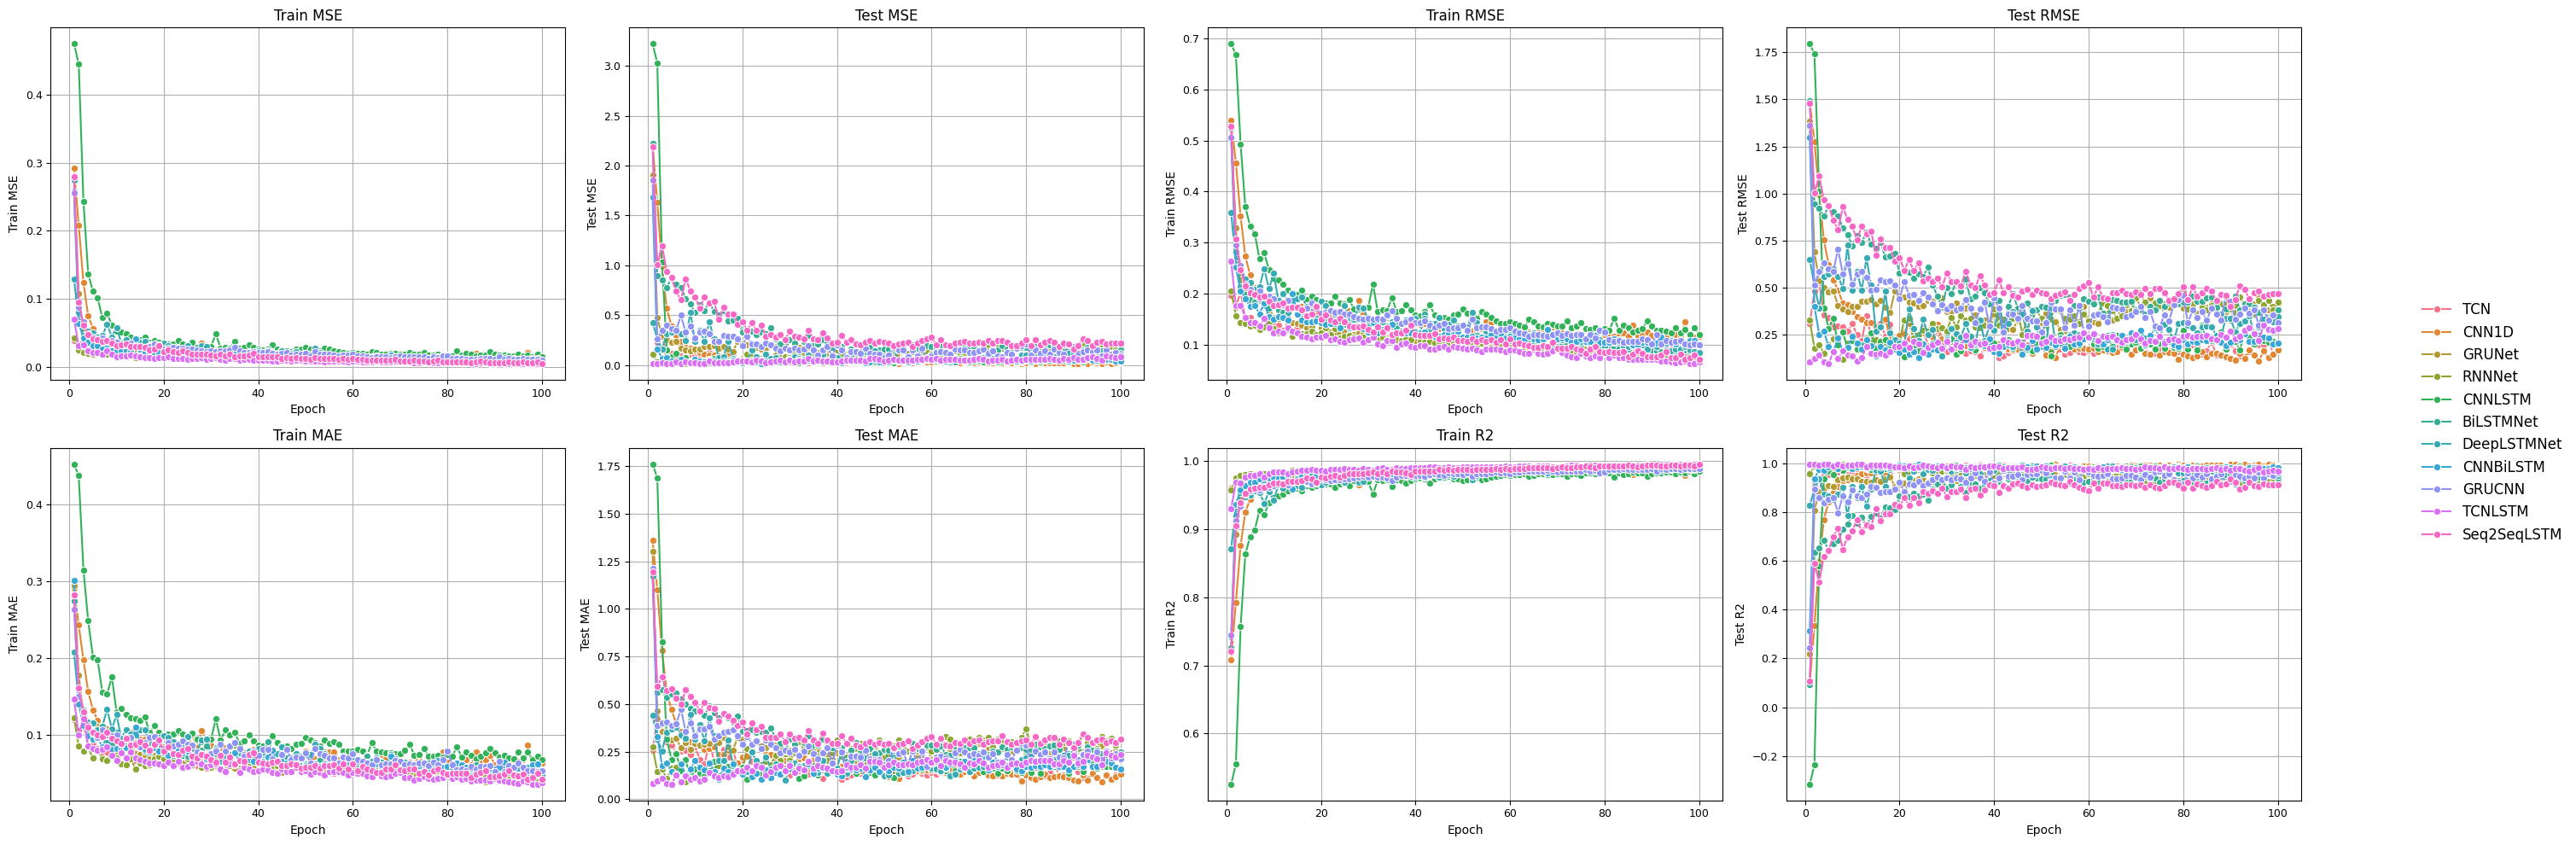

In [30]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", 
          "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]

df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

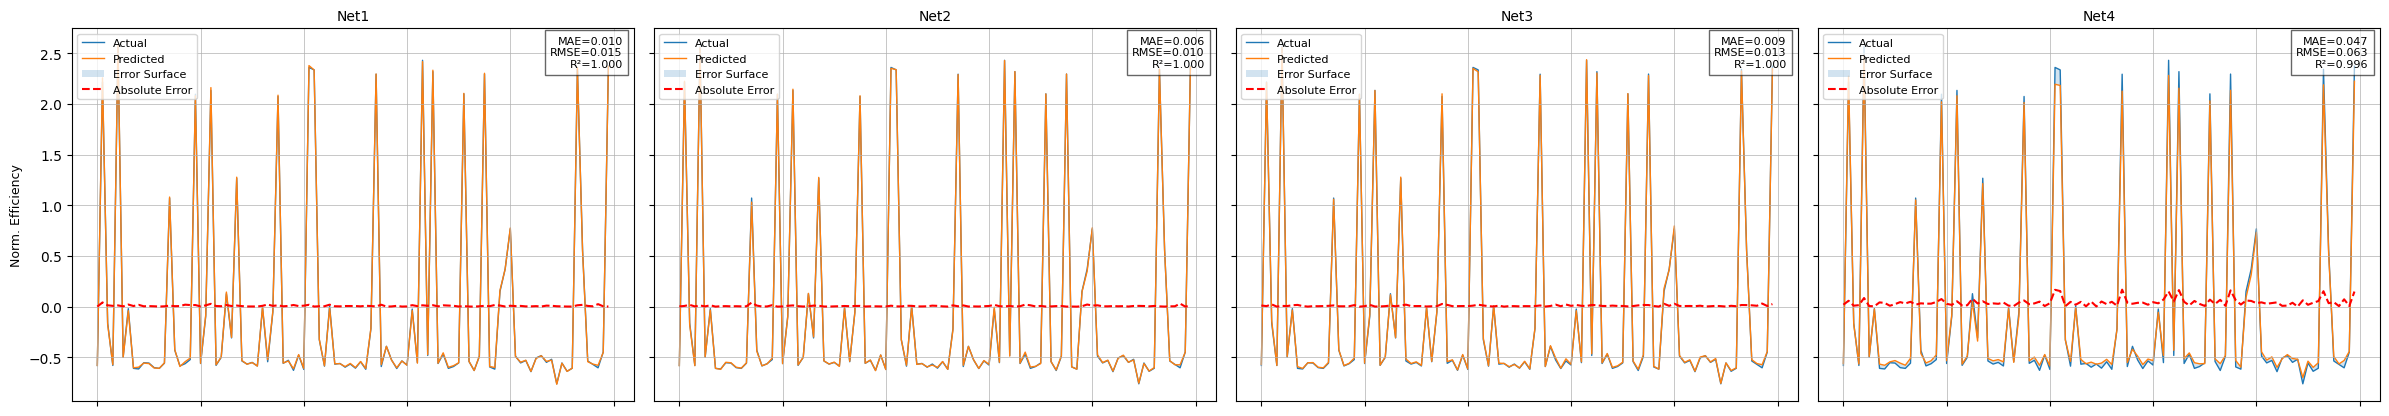

In [31]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)
    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()

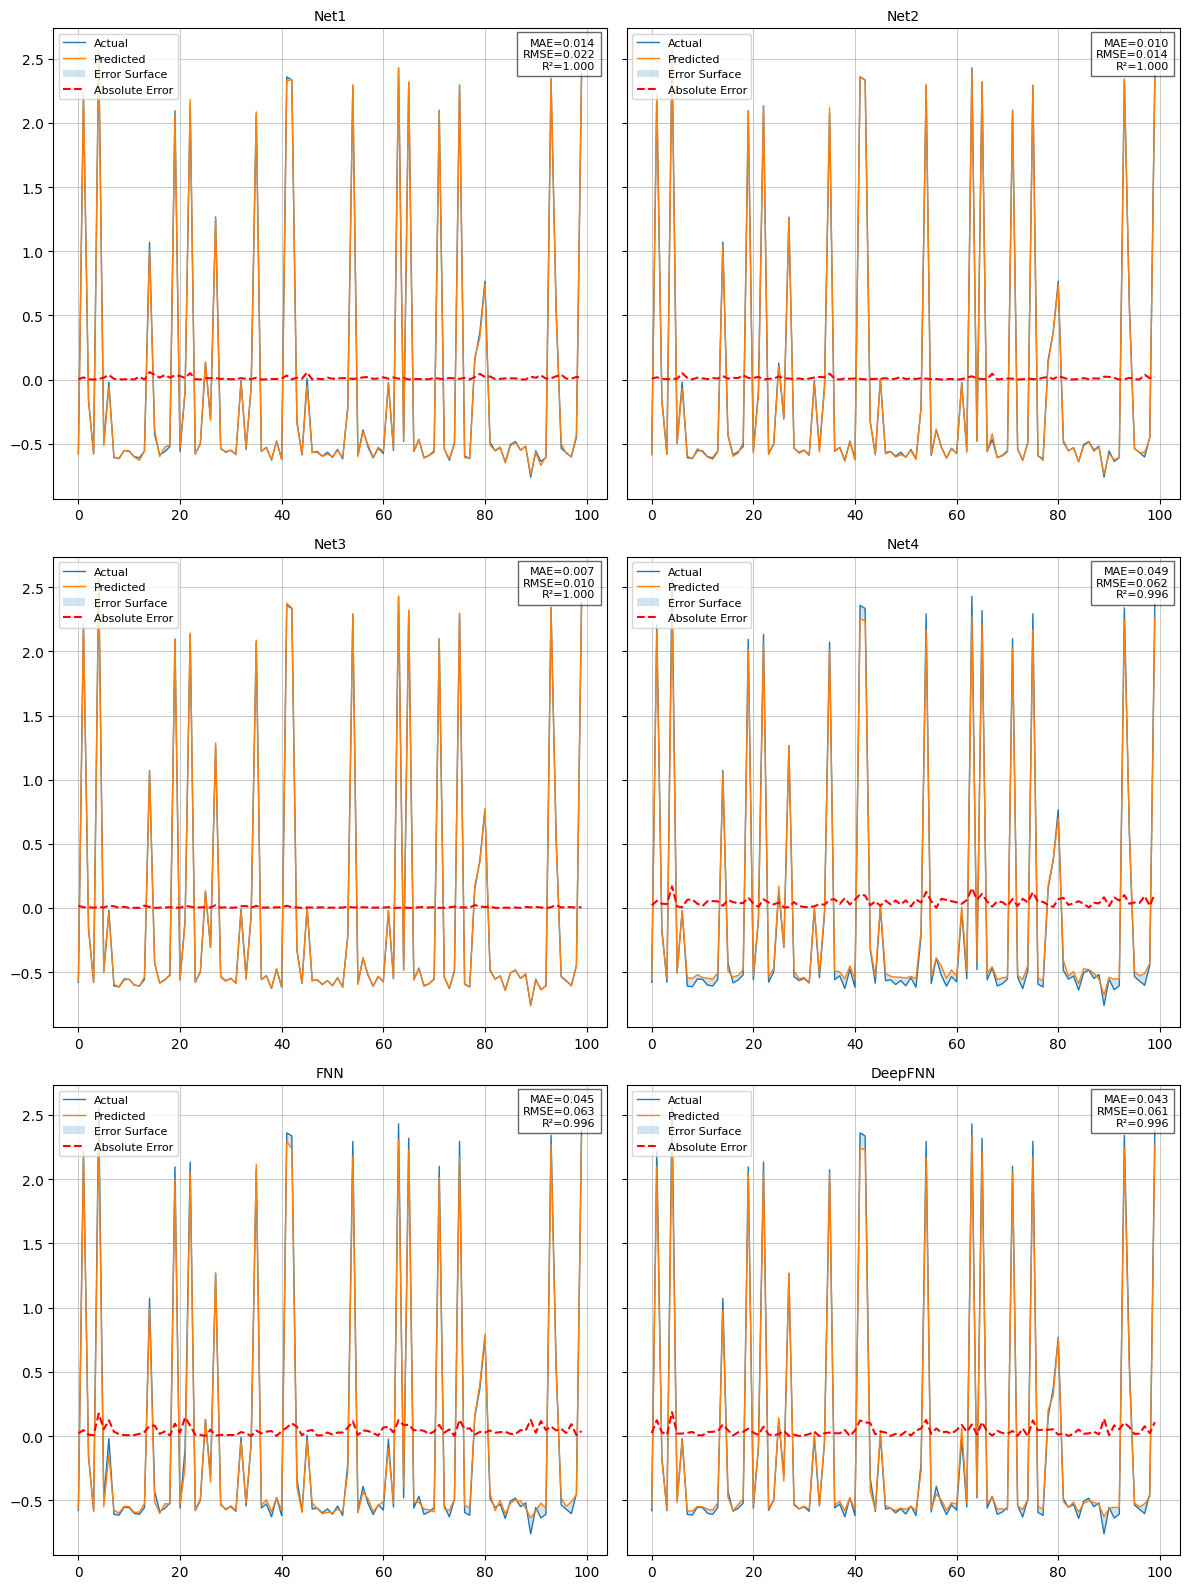

In [32]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
nrows, ncols = 3, 2 

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 16), sharey='row')
axes = axes.flatten()

model_items = list(nets_tabular.items())

for i, (name, model) in enumerate(model_items):
    ax = axes[i]
    model = model.to(device).eval()
    
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

for j in range(len(model_items), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9428/3019501890.py:61: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9428/3019501890.py:61: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


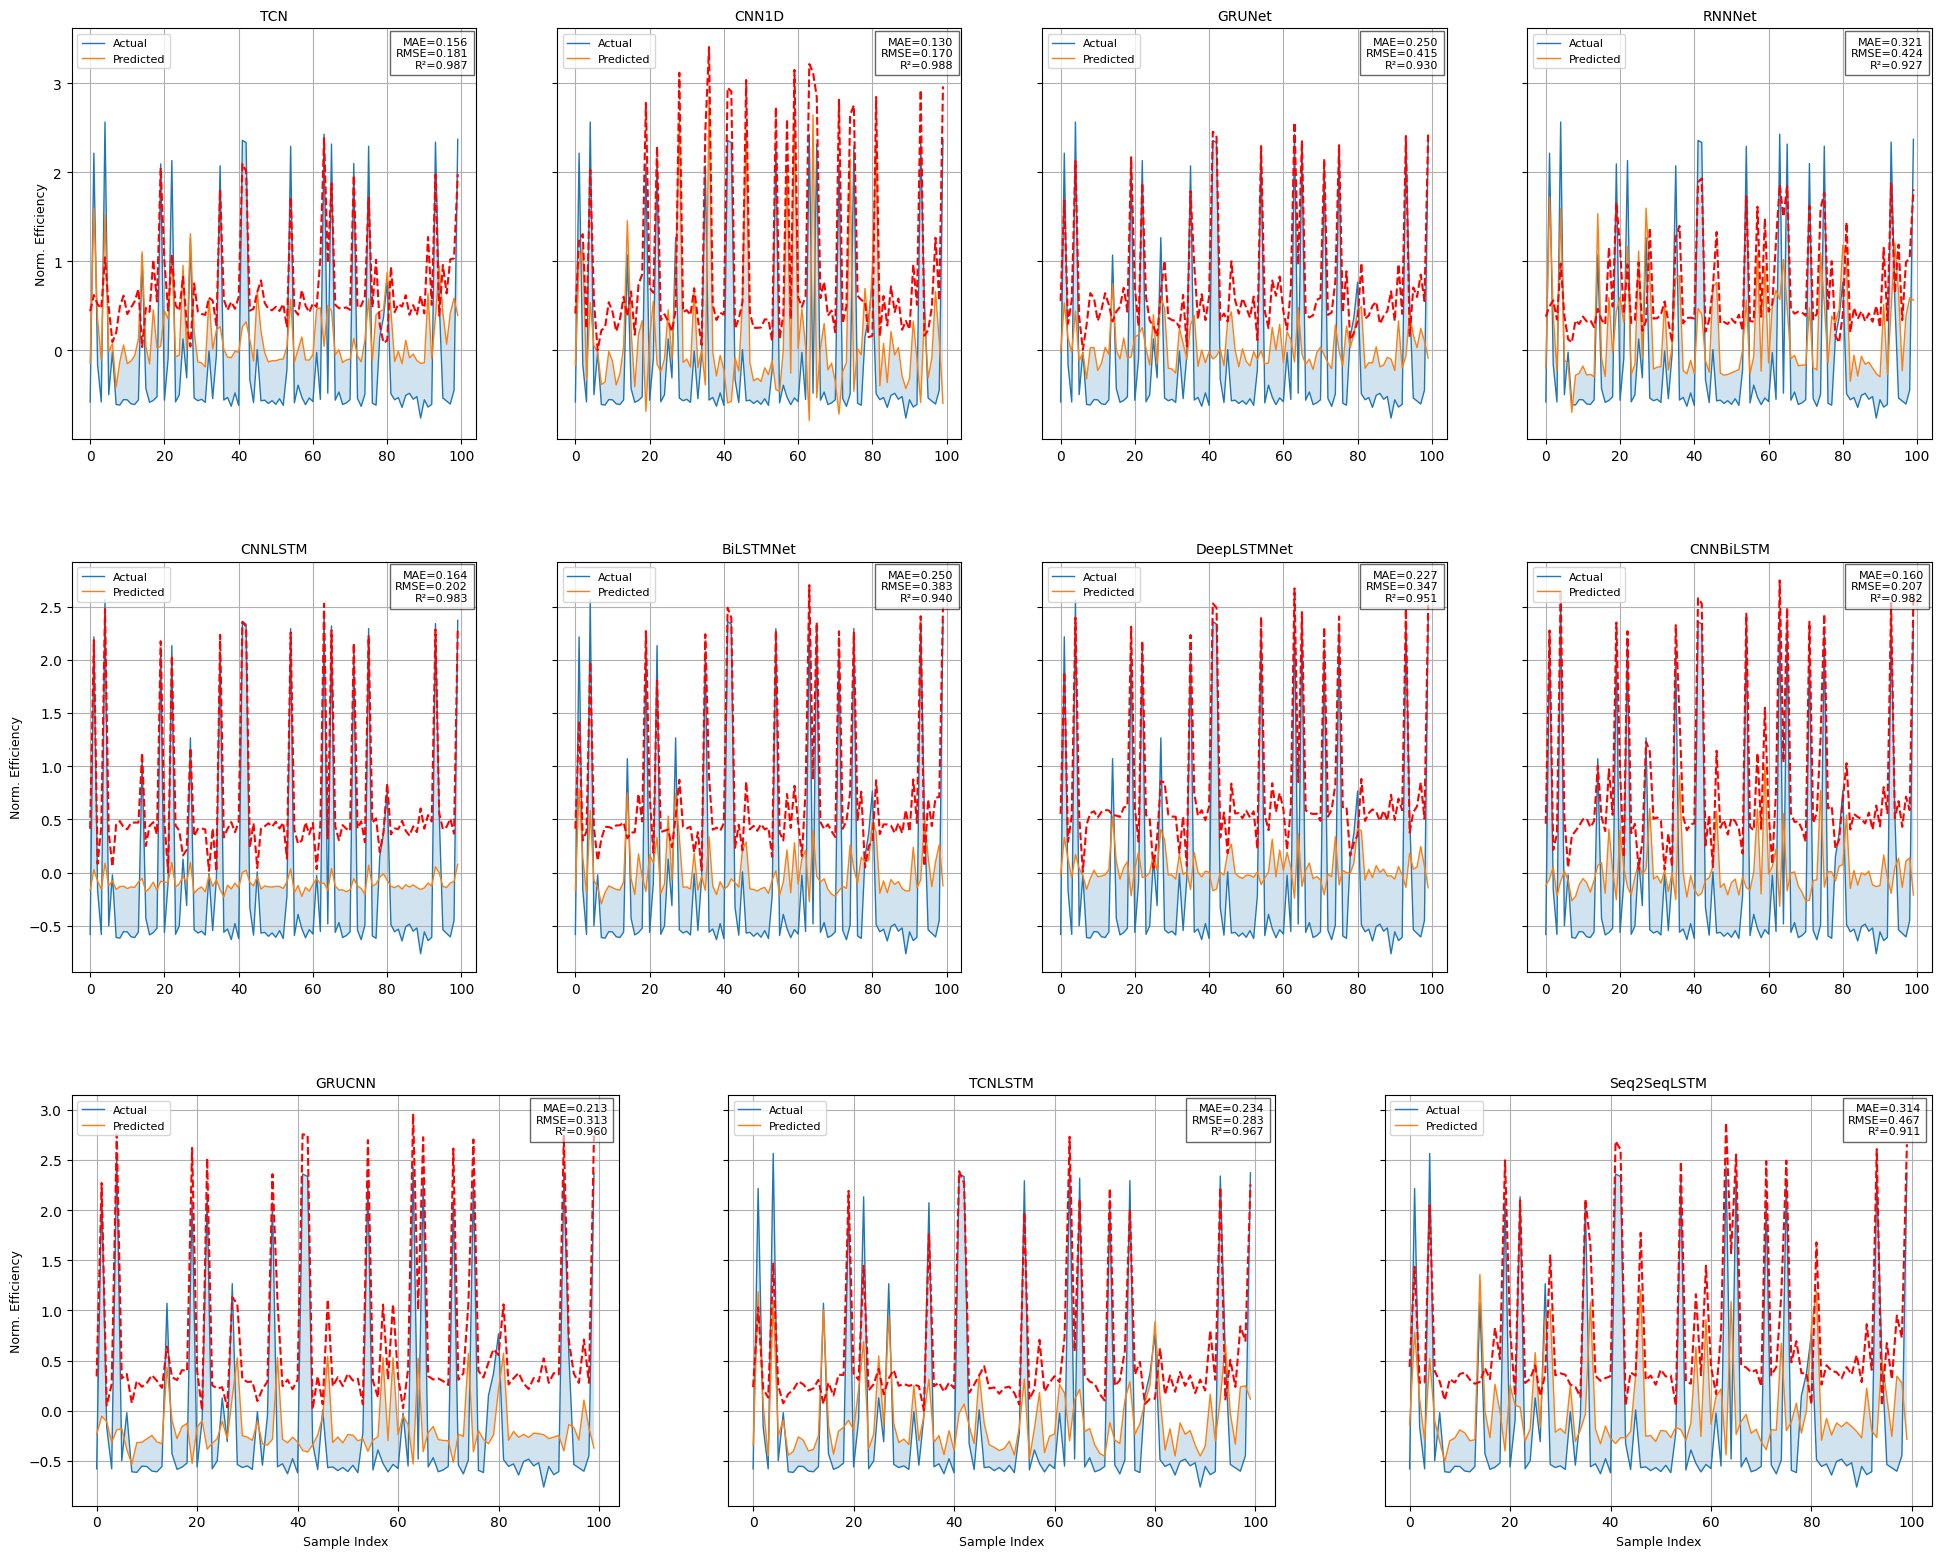

In [48]:
pred_figures_nets_ts = {}
n_models = len(ts_nets)
ncols = 4
full_rows = n_models // ncols   # 2
remainder = n_models % ncols

fig = plt.figure(constrained_layout=True,
                 figsize=(24, 16))
subfigs = fig.subfigures(full_rows + 1, 1,
                         height_ratios=[1]*full_rows + [1])

def plot_model(ax, name, model):
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()
    n = min(100, len(trues))
    idxs = np.linspace(0, n - 1, min(n, 100), dtype=int)
    y_t, y_p = trues[-n:][idxs], preds[-n:][idxs]
    err = np.abs(y_t - y_p)
    ax.plot(idxs, y_t, label="Actual", lw=1)
    ax.plot(idxs, y_p, label="Predicted", lw=1)
    ax.fill_between(idxs, y_t, y_p, alpha=0.2)
    ax.plot(idxs, err, '--', lw=1.5, color='red')
    m = nn_metrics_ts_df.query("Model == @name") \
                        .sort_values("Epoch") \
                        .iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats,
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8, loc="upper left")
    

for i in range(full_rows):
    axs = subfigs[i].subplots(1, ncols,
                              sharex=True,
                              sharey=True)
    for ax, (name, model) in zip(axs, list(ts_nets.items())[i * ncols:(i + 1) * ncols]):
        plot_model(ax, name, model)
    for ax in axs:
        if axs.tolist().index(ax) == 0:
            ax.set_ylabel("Norm. Efficiency", fontsize=9)
        if i == full_rows: 
            ax.set_xlabel("Sample Index", fontsize=9)

axs_last = subfigs[full_rows].subplots(1, remainder,
                                        sharex=True,
                                        sharey=True)
for ax, (name, model) in zip(axs_last, list(ts_nets.items())[full_rows * ncols :]):
    plot_model(ax, name, model)
    if axs_last.tolist().index(ax) == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    ax.set_xlabel("Sample Index", fontsize=9)

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [49]:
save_ml_experiment(
    station="Amberd2",
    results=results,
    y_test=y_test,
    metrics_df=metrics_df,
    table_fig=table_fig,
    barplot_fig=barplot_fig,
    pred_figs=pred_figs,
    models_dict=models,
    base_dir=Path("..")
)

In [50]:
for name, model in nets.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [51]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [52]:
for name, model in ts_nets.items():
    save_experiment(
        station="Amberd2",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )